Ensure that the latest versions of all required packages are installed and that widgets are enabled (for progress bars).

In [1]:
! pip install --upgrade pip --user -q
! pip install --upgrade tqdm --user -q
! pip install --upgrade astropy --user -q
! pip install --upgrade matplotlib --user -q
! pip install --upgrade sklearn --user -q
! pip install --upgrade keras --user -q
! pip install --upgrade tensorflow --user -q
! jupyter nbextension enable --py widgetsnbextension --EnableNBExtensionApp.log_level=0

In [63]:
import time
def progress_range(length, description=''):
    if description != '':
        description += '; '
    return tnrange(length, leave=False, smoothing=0.03, ncols=650,
                   unit=description,
                   bar_format='{n}/|/{unit}Time Remaining: {remaining}')

for i in progress_range(30, 'Reading Spectra'):
    time.sleep(0.2)

In [68]:
from tqdm import tnrange, tqdm_notebook

from multiprocessing import Pool

import os, sys
import tarfile
import warnings

from urllib.request import urlopen, urlretrieve
from urllib.parse import urlparse
from urllib.error import HTTPError

from astropy.table import Table
from astropy.io import fits
from astropy.units import UnitsWarning
from astropy.utils.exceptions import AstropyUserWarning

import numpy as np
import numpy.core.defchararray as np_str
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.optimize import curve_fit

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

################################################################################

# Equivalent to range(length), but also displays a progress bar with an estimate
# estimate of the remaining time.
def progress_range(length, description=''):
    if description != '':
        description += '; '
    return tnrange(length, leave=False, smoothing=0.03, ncols=650,
                   unit=description,
                   bar_format='{n}/|/{unit}Time Remaining: {remaining}')

# Wraps an iterable of the given length and displays a progress bar with an
# estimate estimate of the remaining time.
def progress_wrapper(iterable, length, description=''):
    if description != '':
        description += '; '
    return tqdm_notebook(iterable, total=length, leave=False, smoothing=0.03,
                         ncols=650, unit=description,
                         bar_format='{n}/|/{unit}Time Remaining: {remaining}')

################################################################################

# Speed of light in angstroms per second.
speed_of_light = 2.99792458e18

# Planck's constant in kiloelectronvolt-seconds.
planck_constant = 44173801/1.06811756e25

################################################################################

# Directory which contains zCOSMOS-deep catalogue; may be set to None. This
# catalogue is not publicly available, so it cannot be downloaded automatically.
zdeep_dirname = None

# Name of zCOSMOS-bright catalogue file, which can be extracted from
# https://irsa.ipac.caltech.edu/data/COSMOS/spectra/z-cosmos/zCOSMOS20kDR3.tar.
# Downloading the entire 6GB tar for a single file is absurd, so it is not done
# automatically.
zbright_filename = 'zCOSMOS_VIMOS_BRIGHT_DR3_CATALOGUE.fits'

# Directory in which to automatically download all other reqiured files.
download_dirname = 'downloads'

# Names of the COSMOS2015 catalogue file, the FMOS catalogue directory, and the
# LEGA-C catalogue directory.
cosmos_filename = os.path.join(download_dirname,
                               'COSMOS2015_Laigle+_v1.1.fits.gz')
fmos_dirname = os.path.join(download_dirname, 'FMOS')
legac_dirname = os.path.join(download_dirname, 'LEGA-C')

################################################################################

# If necessary, downloads the COSMOS2015, FMOS, and LEGA-C catalogues.
def check_downloads():
    if not os.path.exists(download_dirname):
        os.makedirs(download_dirname, exist_ok=True)
    
    if not os.path.exists(cosmos_filename):
        url = ('ftp://ftp.iap.fr/pub/from_users/hjmcc/COSMOS2015/'
               'COSMOS2015_Laigle+_v1.1.fits.gz')
        print('Downloading', url, end=' ')
        urlretrieve(url, cosmos_filename)
        print('[Done]')
    
    for url, old_dirname, new_dirname in (('http://member.ipmu.jp/fmos-cosmos/'
                                           'FC_spectra_files/1dspec.tar.gz',
                                           '1dspec', fmos_dirname),
                                          ('http://www2.mpia-hd.mpg.de/home/'
                                           'legac/dr2/legac_dr2_spectra.tar.gz',
                                           'spectraDR', legac_dirname)):
        if not os.path.exists(new_dirname):
            print('Downloading', url, end=' ')
            with tarfile.open(fileobj=urlopen(url), mode='r|gz') as tar_file:
                tar_file.extractall()
            os.rename(old_dirname, new_dirname)
            print('[Done]')

################################################################################

# For every galaxy in the COSMOS2015 catalogue, record that galaxy's
# coordinates (in degrees), its flux through every filter (in erg/s/cm^2/Hz),
# and the error in every flux (in erg/s/cm^2/Hz). Correct the fluxes to account
# for aperture size and foreground extinction. In a separate table, record every
# filter's name and its transmission data (if no transmission data is available,
# simply record its edge wavelengths).
def load_phot_filter_tables():           
    # Read the entire COSMOS2015 catalog, ignoring the warning about poorly
    # formatted units. The table is masked because there are missing values in
    # the ID_XMM, ID_CHANDRA09, and FLAG_XRAYBLEND columns; since those columns
    # are irrelevant, it can be converted to a regular table.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UnitsWarning)
        cosmos_table = Table.read(cosmos_filename).filled()
        
    # Ignore every object that is not a galaxy.
    cosmos_table.remove_rows(cosmos_table['TYPE'] != 0)
    
    # Ignore all masked galaxies.
    cosmos_table.remove_rows(cosmos_table['FLAG_PETER'] != 0)
    
    # Create a list for the columns of the photometric data table, along with a
    # list for their names. Initialize the lists so that they describe the
    # coordinates of each galaxy.
    phot_columns = [cosmos_table['ALPHA_J2000'].data,
                    cosmos_table['DELTA_J2000'].data]
    phot_colnames = ['ra', 'dec']
    
    # Create a list for the rows of the filter data table.
    filter_rows = []
    
    # Record the name of each filter, its description in the COSMOS2015
    # catalogue header, a word that specifies the location of its transmission
    # data file, the name of its transmission data file, and its systematic
    # offset and foreground extinction factor (from columns 4 and 5 of Table 3
    # in the COSMOS2015 paper, https://arxiv.org/pdf/1604.02350.pdf; the values
    # for z+ and GALEX FUV are assumed to be the same as those of z++ and GALEX
    # NUV, respectively, while all other unknown values are assumed to be 0).
    # The NuSTAR filters are not included, since they were not used to measure
    # the fluxes of any galaxies.
    filter_data = [
    ('yHSC',          'O/NIR', 'faisst', 'y_HSC.txt',             -0.014, 1.298),
    ('Y',             'O/NIR', 'capak',  'Y_uv.res',               0.001, 1.211),
    ('J',             'O/NIR', 'capak',  'J_uv.res',               0.017, 0.871),
    ('H',             'O/NIR', 'capak',  'H_uv.res',               0.055, 0.563),
    ('Ks',            'O/NIR', 'capak',  'K_uv.res',              -0.001, 0.364),
    ('Ksw',           'O/NIR', 'capak',  'wircam_Ks.res',          0.068, 0.364),
    ('Hw',            'O/NIR', 'capak',  'wircam_H.res',          -0.031, 0.563),
    ('u',             'O/NIR', 'capak',  'u_megaprime_sagem.res',  0.010, 4.660),
    ('B',             'O/NIR', 'capak',  'B_subaru.res',           0.146, 4.020),
    ('V',             'O/NIR', 'capak',  'V_subaru.res',          -0.117, 3.117),
    ('r',             'O/NIR', 'capak',  'r_subaru.res',          -0.012, 2.660),
    ('ip',            'O/NIR', 'capak',  'i_subaru.res',           0.020, 1.991),
    ('zp',            'O/NIR', 'capak',  'z_subaru.res',          -0.084, 1.461),
    ('zpp',           'O/NIR', 'capak',  'suprime_FDCCD_z.res',   -0.084, 1.461),
    ('IB427',         'O/NIR', 'capak',  'IB427.SuprimeCam.pb',    0.050, 4.260),
    ('IB464',         'O/NIR', 'capak',  'IB464.SuprimeCam.pb',   -0.014, 3.843),
    ('IA484',         'O/NIR', 'capak',  'IB484.SuprimeCam.pb',   -0.002, 3.621),
    ('IB505',         'O/NIR', 'capak',  'IB505.SuprimeCam.pb',   -0.013, 3.425),
    ('IA527',         'O/NIR', 'capak',  'IB527.SuprimeCam.pb',    0.025, 3.264),
    ('IB574',         'O/NIR', 'capak',  'IB574.SuprimeCam.pb',    0.065, 2.937),
    ('IA624',         'O/NIR', 'capak',  'IB624.SuprimeCam.pb',   -0.010, 2.694),
    ('IA679',         'O/NIR', 'capak',  'IB679.SuprimeCam.pb',   -0.194, 2.430),
    ('IA738',         'O/NIR', 'capak',  'IB738.SuprimeCam.pb',    0.017, 2.289),
    ('IA767',         'O/NIR', 'capak',  'IB767.SuprimeCam.pb',    0.020, 2.150),
    ('IB709',         'O/NIR', 'capak',  'IB709.SuprimeCam.pb',    0.024, 1.996),
    ('IB827',         'O/NIR', 'capak',  'IB827.SuprimeCam.pb',   -0.005, 1.747),
    ('NB711',         'O/NIR', 'capak',  'NB711.SuprimeCam.pb',    0.040, 2.268),
    ('NB816',         'O/NIR', 'capak',  'NB816.SuprimeCam.pb',   -0.035, 1.787),
    ('SPLASH_1',      'IRAC',  'capak',  'irac_ch1.res',          -0.025, 0.162),
    ('SPLASH_2',      'IRAC',  'capak',  'irac_ch2.res',          -0.005, 0.111),
    ('SPLASH_3',      'IRAC',  'capak',  'irac_ch3.res',          -0.061, 0.075),
    ('SPLASH_4',      'IRAC',  'capak',  'irac_ch4.res',          -0.025, 0.045),
    ('GALEX_NUV',     'Other', 'capak',  'galex2500.res',          0.128, 8.621),
    ('GALEX_FUV',     'Other', 'capak',  'galex1500.res',          0.128, 8.621),
    ('24',            'Other', 'capak',  'mips24.res',             0.000, 0.000),
    ('100',           'Other', 'capak',  'PACS_filter_100.txt',    0.000, 0.000),
    ('160',           'Other', 'capak',  'PACS_filter_160.txt',    0.000, 0.000),
    ('250',           'Other', 'capak',  'SPIRE_filter_250.txt',   0.000, 0.000),
    ('350',           'Other', 'capak',  'SPIRE_filter_350.txt',   0.000, 0.000),
    ('500',           'Other', 'capak',  'SPIRE_filter_500.txt',   0.000, 0.000),
    ('814W',          'Other', 'svo',    'ACS_HRC.F814W',          0.000, 0.000),
    ('20CM',          'VLA',    None,     None,                    0.000, 0.000),
    ('90CM',          'VLA',    None,     None,                    0.000, 0.000),
    ('CHANDRA_0.5_2', 'X-Ray',  None,     None,                    0.000, 0.000),
    ('CHANDRA_2_10',  'X-Ray',  None,     None,                    0.000, 0.000),
    ('XMM_0.5_2',     'X-Ray',  None,     None,                    0.000, 0.000),
    ('XMM_2_10',      'X-Ray',  None,     None,                    0.000, 0.000)]
    
    for name, description, location, filename, offset, factor in filter_data:
        # Determine the name of the column in the COSMOS2015 catalogue that
        # contains the fluxes for this filter, along with the name of the column
        # that contains the errors for those fluxes (if available).
        if description == 'O/NIR':
            flux_colname = name + '_FLUX_APER3'
            error_colname = name + '_FLUXERR_APER3'
        elif description == 'IRAC':
            flux_colname =  name + '_FLUX'
            error_colname = name + '_FLUX_ERR'
        elif description == 'VLA':
            flux_colname = 'FLUXINT_' + name
            error_colname = 'FLUXINTERR_' + name
        elif description == 'X-Ray':
            flux_colname = 'FLUX_' + name
            error_colname = None
        else:
            flux_colname = 'FLUX_' + name
            error_colname = 'FLUXERR_' + name
            
        # Get the columns that contain the fluxes and errors for this filter.
        # Replace every unknown flux and its corresponding error with NaN (a
        # flux is unknown when its error is negative). If no errors are
        # available, denote every error by NaN.
        flux_col = cosmos_table[flux_colname]
        if error_colname:
            error_col = cosmos_table[error_colname]
            is_unknown = np.less_equal(error_col, 0,
                                       out=np.full(len(cosmos_table), True),
                                       where=~np.isnan(error_col))
            flux_col[is_unknown] = np.nan
            error_col[is_unknown] = np.nan
        else:
            error_col = flux_col.copy()
            error_col[:] = np.nan
        
        # Calculate the factor by which each flux must be multiplied to be in
        # CGS units (erg/s/cm^2/Hz). Most fluxes are in multiples of Janskys, so
        # the conversion is simple because 1 Jy = 1e-23 erg/s/cm^2/Hz. The X-Ray
        # fluxes are given as ordinary fluxes instead of flux densities with
        # respect to frequency, so they must be divided by the width of the
        # filter in Hz, which can be determined from the name of the filter.
        # Although the values that correspond to the 814W filter are labeled as
        # fluxes in mJy, they are actually AB magnitudes, so they must be
        # converted to fluxes and their errors must be corrected appropriately.
        if name == '814W':
            flux_col = 10.0 ** (-0.4 * (flux_col + 48.6))
            error_col = np.abs(-0.4 * np.log(10.0) * flux_col) * error_col
            to_cgs = 1
        elif flux_col.unit == 'uJy':
            to_cgs = 1e-29
        elif flux_col.unit == 'mJy':
            to_cgs = 1e-26
        elif flux_col.unit == 'erg / (cm2 s)':
            energies = list(map(float, name.split('_')[1:]))
            to_cgs = planck_constant / (energies[1] - energies[0])
        
        # Calculate the correction factor for the fluxes. As specified in the
        # appendix of the COSMOS2015 paper, the AB magnitude m of an object with
        # photometric offset o and reddenning value EBV that is measured through
        # a filter with systematic offset s and extinction factor F should be
        # corrected to m + o - s - EBV * F.
        correction = 10.0 ** (-0.4 * (cosmos_table['OFFSET'] - offset -
                                      cosmos_table['EBV'] * factor))
    
        # Add the corrected fluxes and errors in CGS units to the list of
        # photometric data table columns, and update the list of column names.
        phot_columns.append(flux_col.data * to_cgs * correction)
        phot_columns.append(error_col.data * to_cgs * correction)
        phot_colnames.append(name)
        phot_colnames.append(name + '_ERR')
        
        # If it exists, get the transmission data for this filter, and use it to
        # determine the wavelengths the filter covers and the fraction of flux
        # that is transmitted at each wavelength, ignoring every leading and
        # trailing 0 in the list of transmissions. Otherwise, only determine the
        # minimum and maximum wavelengths, and denote the transmissions by None.
        # The wavelengths of the VLA filters can be determined using the
        # frequencies from https://science.nrao.edu/facilities/vla/docs/manuals/
        # oss2013B/performance/bands, and the wavelengths of the X-Ray filters
        # can be determined from the energies calculated earlier.
        if filename:
            if location == 'capak':
                path = 'http://www.astro.caltech.edu/~capak/filters/'
            elif location == 'faisst':
                path = ('http://www.astro.caltech.edu/~afaisst/files/'
                        'cosmos_filter/')
            elif location == 'svo':
                path = ('http://svo2.cab.inta-csic.es/svo/theory/fps3/'
                        'getdata.php?format=ascii&id=HST/')
            transmission_data = Table.read(path + filename, format='ascii')
            wavelengths = transmission_data.columns[0].data.astype('f')
            transmissions = transmission_data.columns[1].data
            is_nonzero = transmissions != 0
            index1 = np.argmax(is_nonzero)
            index2 = len(is_nonzero) - is_nonzero[::-1].argmax()
            wavelengths = wavelengths[index1:index2]
            transmissions = transmissions[index1:index2]
        else:
            if name == '20CM':
                wavelengths = speed_of_light / np.array([2e9, 1e9])
            elif name == '90CM':
                wavelengths = speed_of_light / np.array([0.47e9, 0.23e9])
            else:
                wavelengths = (speed_of_light * planck_constant /
                               np.array(energies)[::-1])
            transmissions = None
            
        # Use the transmission data to determine the average wavelength of light
        # that passes through the filter.
        avg_wavelength = np.average(wavelengths, weights=transmissions)
        
        # Add the filter information to the list of filter data table rows.
        filter_rows.append((name, avg_wavelength, wavelengths, transmissions))

    # Convert all the photometric data and filter data into tables.
    phot_table = Table(phot_columns, names=phot_colnames)
    filter_table = Table(rows=filter_rows,
                         names=('name', 'avg_wavelength', 'wavelengths',
                                'transmissions'))
    return phot_table, filter_table

################################################################################

# For every spectrum file, load the name of the catalogue that led to the file
# and the path to the file (either a url or a file system path), along with the
# the coordinates and spectroscopic redshift of the galaxy associated with each
# spectrum. If bad redshifts are ignored, spectra with unknown or 0 redshifts
# are not included; otherwise, every unknown redshift is denoted by NaN.
def load_spec_table(ignore_bad_zs=True):
    ras = []
    decs = []
    names = []
    paths = []
    zs = []
    
    # Record the data from a particular catalogue.
    def add_data(catalogue_name, catalogue_table,
                 ra_colname, dec_colname, path_list,
                 ra_fun=None, dec_fun=None, path_fun=None,
                 z_colname=None, unknown_z_value=None, unknown_z_value2=None,
                 star_colname=None, star_value=None, star_substr=None):
        # Remove all stars from the catalogue if they are indicated in some
        # column. Either compare the values in that column to some value, or
        # search the strings in that column for some substring.
        if star_colname:
            star_col = catalogue_table[star_colname]
            if star_substr:
                is_star = np_str.find(np_str.lower(star_col), star_substr) != -1
            else:
                is_star = star_col == star_value
            catalogue_table.remove_rows(is_star)

        # Record the redshifts from the catalogue, if they are indicated in some
        # column. Otherwise, use NaN for every redshift.
        if z_colname:
            # If unknown redshifts are indicated by some value, either remove
            # all rows with unknown redshifts, or replace every unknown redshift
            # with NaN, depending on whether bad redshifts should be ignored. If
            # the redshifts weren't already floating-point values, convert them.
            if unknown_z_value:
                z_col = catalogue_table[z_colname]
                if (ignore_bad_zs and z_col.dtype.kind == 'f' and
                    np.isnan(unknown_z_value)):
                    catalogue_table.remove_rows(np.isnan(z_col))
                else:
                    unknown_zs = z_col == unknown_z_value
                    if unknown_z_value2:
                        unknown_zs = np.logical_or(unknown_zs,
                                                   z_col == unknown_z_value2)
                    if ignore_bad_zs:
                        catalogue_table.remove_rows(unknown_zs)
                    else:
                        z_col[unknown_zs] = z_col.dtype.type(np.nan)
                    if z_col.dtype.kind != 'f':
                        float_z_col = catalogue_table[z_colname].astype('f')
                        catalogue_table.replace_column(z_colname, float_z_col)

            # If bad redshifts should be ignored, remove all rows with 0
            # redshifts.
            if ignore_bad_zs:
                zero_zs = catalogue_table[z_colname] == 0
                catalogue_table.remove_rows(zero_zs)

            new_zs = catalogue_table[z_colname]
        else:
            new_zs = np.full(len(catalogue_table), np.nan)

        # Record the coordinates from the catalogue, optionally applying a
        # function to each coordinate.
        new_ras = catalogue_table[ra_colname]
        new_decs = catalogue_table[dec_colname]
        if ra_fun:
            new_ras = np.vectorize(ra_fun)(new_ras)
        if dec_fun:
            new_decs = np.vectorize(dec_fun)(new_decs)

        # Record the paths to the spectra from the catalogue. For each string in
        # the path list, if the string is the name of a column, add the strings
        # in that column to the paths, optionally applying a function to each
        # string. Otherwise, just add the string to each path.
        new_paths = np.full(len(catalogue_table), '')
        for string in path_list:
            if string in catalogue_table.colnames:
                path_col = catalogue_table[string].astype('U')
                if path_fun:
                    path_col = np.vectorize(path_fun)(path_col)
                new_paths = np_str.add(new_paths, path_col)
            else:
                new_paths = np_str.add(new_paths, string)

        # Add all the recorded information to the given lists.
        ras.append(new_ras)
        decs.append(new_decs)
        names.append(np.full(len(catalogue_table), catalogue_name))
        paths.append(new_paths)
        zs.append(new_zs)
    
    #-----------------------------------IPAC-----------------------------------#
    
    # Record the url that will be prepended to every IPAC path.
    ipac_url = 'https://irsa.ipac.caltech.edu/data/COSMOS/'
    
    # Load the DEIMOS catalogue.
    deimos_catalogue = Table.read(ipac_url + 'tables/spectra/' +
                                  'deimos_redshift_linksIRSA.tbl',
                                  format='ipac')
    
    # Ignore all rows without paths to the associated spectra.
    deimos_catalogue.remove_rows(deimos_catalogue['ascii1d'].mask)

    # Since some paths were missing, the table is masked. Convert the
    # masked table to a regular table.
    deimos_catalogue = deimos_catalogue.filled()
    
    # Add the data from the DEIMOS catalogue.
    add_data('DEIMOS', deimos_catalogue, 'ra', 'dec', [ipac_url, 'fits1d'],
             path_fun=lambda s: s.split('"')[1][13:], z_colname='zspec',
             unknown_z_value='NA', star_colname='Remarks', star_substr='star')
    
    # Add the data from the Magellan catalogue.
    add_data('Magellan',
             Table.read(ipac_url + 'tables/spectra/magellan_opt_spec_30.tbl',
                        format='ipac'),
             'ra', 'dec', [ipac_url, 'FITS_u'], z_colname='redshift',
             unknown_z_value=-1, star_colname='class', star_value='star')
    
    # Add the data from the zCOSMOS-bright catalogue, which does not indicate
    # stars.
    add_data('zCOSMOS-bright', Table.read(zbright_filename),'RAJ2000',
             'DEJ2000', [ipac_url + 'spectra/z-cosmos/DR3/', 'FILENAME'],
             z_colname='REDSHIFT', unknown_z_value=np.nan)
        
    #-----------------------------------C3R2-----------------------------------#
        
    # Converts a string of the form hh:mm:ss to degrees.
    def ra_to_deg(s):
        return 15 * float(s[0:2]) + float(s[3:5]) / 4 + float(s[6:]) / 240

    # Converts a string of the form (+/-)dd:mm:ss to degrees.
    def dec_to_deg(s):
        if s[0] == '+':
            return float(s[1:3]) + float(s[4:6]) / 60 + float(s[7:]) / 3600
        elif s[0] == '-':
            return -float(s[1:3]) - float(s[4:6]) / 60 - float(s[7:]) / 3600
        else:
            return float(s[0:2]) + float(s[3:5]) / 60 + float(s[6:]) / 3600
    
    # Record the url that will be prepended to every C3R2 path.
    c3r2_url = 'https://koa.ipac.caltech.edu/data/Contributed/C3R2/'
    
    # Add the data from the C3R2 catalogue, which does not indicate unknown
    # redshifts or stars, and which does not come with column names.
    add_data('C3R2',
             Table.read(c3r2_url + 'c3r2_targets_2019mar28.txt', data_start=17,
                        format='ascii.no_header'),
             'col2', 'col3', [c3r2_url + 'spec1d/', 'col10'],
             ra_fun=ra_to_deg, dec_fun=dec_to_deg, z_colname='col7')
    
    #-----------------------------------FMOS-----------------------------------#
    
    # Record the first part of the path list for every FMOS path.
    fmos_path_list = [fmos_dirname + os.path.sep, 'FMOS_ID', '_']

    # Load the FMOS catalogue.
    fmos_catalogue = Table.read('http://member.ipmu.jp/fmos-cosmos/'
                                'FC_catalogs_files/FMOS_COSMOS_v1.0.fits')

    # Add the data for H-Long spectra from the FMOS catalogue.
    add_data('FMOS', fmos_catalogue, 'RA', 'DEC',
             fmos_path_list + ['DATE_OBS_HL', '_hl_1d.fits'], z_colname='ZSPEC',
             unknown_z_value=-999, star_colname='TYPE', star_value=1)

    # Ignore all rows that do not have associated J-Long spectra.
    fmos_catalogue.remove_rows(fmos_catalogue['OBS_JL'] == 0)

    # Add the data for J-Long spectra from the FMOS catalogue. Since all the
    # stars were already removed and all the bad redshifts were already
    # removed/replaced, there is no need to pass that information again.
    add_data('FMOS', fmos_catalogue, 'RA', 'DEC',
             fmos_path_list + ['DATE_OBS_JL', '_jl_1d.fits'], z_colname='ZSPEC')
    
    #----------------------------------LEGA-C----------------------------------#
    
    # Add the data from the LEGA-C catalogue, which does not indicate stars.
    # Ignore the warning about poorly formatted units.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UnitsWarning)
        add_data('LEGA-C',
                 Table.read('http://www.mpia.de/home/legac/dr2/'
                            'legac_dr2_cat.fits.gz'),
                 'RAJ2000', 'DECJ2000',
                 [legac_dirname + os.path.sep, 'Filename'],
                 path_fun=lambda s: s.rstrip(' '),
                 z_colname='z', unknown_z_value=np.nan)
    
    #-------------------------------ZCOSMOS-DEEP-------------------------------#
    
    # If it exists, add the data from the zCOSMOS-deep catalogue, which does not
    # indicate stars.
    if zdeep_dirname:
        add_data('zCOSMOS-deep',
                 Table.read(os.path.join(zdeep_dirname, 'catalogs', 'DEEP_'
                                         'zcosmos_spectroscopy_one_v2.6.data'),
                            format='ascii'),
                 'ra', 'dec',
                 [os.path.join(zdeep_dirname, 'spectra', 'LB'), 'pointing',
                  os.path.join(os.path.sep + '1DFiles', 'sc_000'), 'id',
                  '_ZCLBa', 'pointing', '_M1_blue_', 'slit', '_', 'obj',
                  '_cal_clean.fits'],
                 z_colname='zspec', unknown_z_value=9.9999,
                 unknown_z_value2=9.999)
    
    #--------------------------------------------------------------------------#
    
    # Convert all the gathered data into a single table.
    return Table(list(map(np.concatenate, (ras, decs, names, paths, zs))),
                 names=('ra', 'dec', 'name', 'path', 'z'))

################################################################################

# Given two arrays that specify points (x1, y1) and two arrays that specify
# points (x2, y2), find all pairs of indices (index1, index2) for which the
# point (x1, y1) at index1 and the point (x2, y2) at index2 have coordinates
# such that abs(x1 - x2) and abs(y1 - y2) are less than the specified tolerance
# tol. If duplicates are not allowed, only the closest match for (x1, y1) is
# selected; i.e., if (x1, y1) and (x2, y2) are selected, there is no other point
# (x2, y2) that is closer to (x1, y1).
def find_matches(x_array1, y_array1, x_array2, y_array2, tol,
                 allow_duplicates=False):
    # Get the lengths of the x-arrays (which are the same as the lengths of the
    # corresponding y-arrays).
    length1 = len(x_array1)
    length2 = len(x_array2)
    
    # Get the indices that sort the x-arrays and use them to sort the arrays.
    sorting_indices1 = np.argsort(x_array1)
    sorting_indices2 = np.argsort(x_array2)
    sorted_x_array1 = x_array1[sorting_indices1]
    sorted_x_array2 = x_array2[sorting_indices2]
    
    if allow_duplicates:
        # Initialize two lists of matching indices.
        matching_indices1 = []
        matching_indices2 = []
        
    else:
        # Initialize dictionaries that map the incides of points (x1, y1) to
        # their closest matches (x2, y2) and to the distances to those matches.
        index1_to_index2 = {}
        index1_to_dist = {}
    
    # Iterate through the sorted x-arrays, looking for two x-coordinates x1 and
    # x2 within tol of each other. When two such x-coordinates are found, check
    # whether the corresponding y-coordinates y1 and y2 are also within tol of
    # each other. This may take some time.
    sorted_index2 = 0
    for sorted_index1 in progress_range(length1, 'Finding Matches'):
        # Get x1, the x-coordinate at the current index in the first sorted
        # x-array.
        x1 = sorted_x_array1[sorted_index1]

        # Iterate through the second sorted x-array until x1 < x2' + tol, where
        # x2' is the x-coordinate at the current index in the second sorted
        # x-array.
        while (sorted_index2 < length2 and
               x1 >= sorted_x_array2[sorted_index2] + tol):
            sorted_index2 += 1

        # Iterate through the second sorted x-array while x1 > x2 - tol, where
        # x2 is an x-coordinate at or after the current index in the second
        # sorted x-array. Since x2 >= x2' and x1 < x2' + tol, it must be the
        # case that x1 < x2 + tol. Therefore, x1 and x2 are within tol of each
        # other when x1 > x2 - tol.
        temp_sorted_index2 = sorted_index2
        while (temp_sorted_index2 < length2 and
               x1 > sorted_x_array2[temp_sorted_index2] - tol):
            # Get the indices of x1 and x2 in the original (unsorted) x-arrays.
            index1 = sorting_indices1[sorted_index1]
            index2 = sorting_indices2[temp_sorted_index2]
            
            # Get the y-coordinates y1 and y2 that correspond to x1 and x2.
            y1 = y_array1[index1]
            y2 = y_array2[index2]
            
            # Check whether y1 and y2 are also within tol of each other.
            if y1 < y2 + tol and y1 > y2 - tol:
                if allow_duplicates:
                    matching_indices1.append(index1)
                    matching_indices2.append(index2)
                
                else:
                    x2 = sorted_x_array2[temp_sorted_index2]
                    dist = np.sqrt(np.square(x1 - x2) + np.square(y1 - y2))

                    # If there is no closer match for (x1, y1), update the
                    # dictionaries.
                    if (index1 not in index1_to_dist or
                        dist < index1_to_dist[index1]):
                        index1_to_dist[index1] = dist
                        index1_to_index2[index1] = index2
            
            temp_sorted_index2 += 1
    
    # Return the closest matches as two arrays, with each index1 in the
    # first array and each corresponding index2 in the second array.
    if allow_duplicates:
        return np.array(matching_indices1), np.array(matching_indices2)
    else:
        return (np.array(list(index1_to_index2.keys())),
                np.array(list(index1_to_index2.values())))

################################################################################

# Given the spectroscopic table, find approximate errors for the zCOSMOS-bright
# spectra by interpolating/axtrapolating the median errors of the LEGA-C
# spectra, which were measured with the same instruments.
def get_zbright_errors(spec_table):
    # Load the parts of the spectroscopic table related to each catalogue.
    legac_table = spec_table[spec_table['name'] == 'LEGA-C']
    zbright_table = spec_table[spec_table['name'] == 'zCOSMOS-bright']
    
    # Record the wavelengths used in each catalogue by looking at the first
    # spectrum in each catalogue.
    with fits.open(legac_table['path'][0]) as hdus:
        legac_wavelengths = hdus[1].data[0][0]
    with fits.open(zbright_table['path'][0]) as hdus:
        zbright_wavelengths = hdus[1].data[0][0]
        
    # Record all of the errors in the LEGA-C catalogue. This may take some time.
    errors = np.zeros((len(legac_wavelengths), len(legac_table)))
    for spectrum_num in progress_range(len(legac_table),
                                       'Recording LEGA-C Errors'):
        with fits.open(legac_table['path'][spectrum_num]) as hdus:
            errors[:, spectrum_num] = hdus[1].data[0][2]
    
    # An unknown error is denoted by either 0 or NaN. Convert every 0 to an NaN.
    errors = np.where(errors == 0, np.nan, errors)
    
    # The distribution of errors at every wavelength is quite erratic, with
    # a few values on the order of 1e5 interspersed among values on the order of
    # 10. If the mean of the errors at every wavelength is calculated, the large
    # values dominate the mean, even though they do not convey much information.
    # Therefore, the median of the errors should be calculated instead of the
    # mean. Furthermore, there are a lot of unknown errors at very short and
    # very long wavelengths, which causes the median errors at those wavelengths
    # to oscillate chaotically. This can be avoided by only using wavelengths at
    # which a sufficient number of errors are known.
    is_enough_known = np.sum(~np.isnan(errors), axis=1) >= 100
    legac_wavelengths = legac_wavelengths[is_enough_known]
    median_errors = np.nanmedian(errors[is_enough_known], axis=1)
        
    # Record the indices that separate the zCOSMOS-bright wavelengths that
    # overlap with the remaining LEGA-C wavelengths from those that do not.
    index1 = np.argmax(zbright_wavelengths >= legac_wavelengths[0])
    index2 = np.argmax(zbright_wavelengths >= legac_wavelengths[-1])
    
    # Interpolate the median errors to the zCOSMOS-bright wavelengths that
    # overlap with the LEGA-C wavelengths.
    interpolation = interp1d(legac_wavelengths, median_errors)
    interp_errors = interpolation(zbright_wavelengths[index1:index2])
    
    # Extrapolate the median errors to the zCOSMOS-bright wavelengths that do
    # not overlap with the LEGA-C wavelengths. In order to improve the
    # extrapolation, use a median filter to remove the effects of atmosphereic
    # emission/absorption lines from the errors, leaving behind just the effects
    # of the instrumentation. Then, fit the sum of two exponentials and a
    # constant to the filtered errors at short and long wavelengths, and
    # evaluate the fitted function at the non-overlapping wavelengths.
    def fitting_fun(x, a1, b1, a2, b2, c):
        return a1 * np.exp(b1 * x) + a2 * np.exp(b2 * x) + c
    num_to_fit = 700
    fitting_wavelengths = np.concatenate((legac_wavelengths[:num_to_fit],
                                          legac_wavelengths[-num_to_fit:]))
    filtered_errors = medfilt(median_errors, 81)
    fitting_errors = np.concatenate((filtered_errors[:num_to_fit],
                                     filtered_errors[-num_to_fit:]))
    params = curve_fit(fitting_fun, fitting_wavelengths, fitting_errors,
                       p0=(1e18, -1e-3, 1e-30, 1e-2, 1), maxfev=100000)[0]
    extrap_errors1 = fitting_fun(zbright_wavelengths[:index1], *params)
    extrap_errors2 = fitting_fun(zbright_wavelengths[index2:], *params)
    
    # Combine the interpolated and extrapolated errors.
    return np.concatenate((extrap_errors1, interp_errors, extrap_errors2))

# Given the name of a catalogue and the path to a spectrum file (in FITS format)
# from that catalogue, return an array of wavelengths (in Angstroms), an array
# of corresponding fluxes (in arbitrary units), and an array of errors on those
# fluxes. Ignore all unknown fluxes, which either have values of 0 or NaN or
# have errors that are non-positive, Inf, or NaN. If the file records flux
# errors, thy may be scaled so that their average is the standard deviation of
# the flux noise. Otherwise, downsample the fluxes into bins with the given
# number of wavelengths, and use the standard devaition of each bin as its
# error. Although zCOSMOS-bright files do not record flux errors, an array of
# errors may be passed, and these errors will be scaled to match the noise.
def read_spec_file(name, path, zbright_errors=None, scale_errors=False,
                   wavelengths_per_bin=5):
    # If the path is a url, open the url and check whether it is valid. If the
    # url is invalid, return three empty arrays.
    if urlparse(path).scheme.lower() in ['http', 'https']:
        try:
            path = urlopen(path)
        except HTTPError:
            return np.empty(0, 'f8'), np.empty(0, 'f8'), np.empty(0, 'f8')
        
    # Read the entire FITS file, ignoring any warnings about invalid header
    # keywords. Record the wavelengths, fluxes, and errors for all known fluxes.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', AstropyUserWarning)
        with fits.open(path, cache=False) as hdus:
            if name == 'zCOSMOS-bright':
                fluxes = hdus[1].data['FLUX_REDUCED'][0]
                is_known = np.logical_and(~np.isnan(fluxes), fluxes != 0)
                wavelengths = hdus[1].data['WAVE'][0][is_known]
                fluxes = fluxes[is_known]
                if not zbright_errors is None:
                    errors = zbright_errors[is_known].copy()
                else:
                    errors = None
            elif name == 'DEIMOS':
                inverse_variances = hdus[1].data['IVAR'][0]
                if 'FLUX' in hdus[1].data.dtype.names:
                    fluxes = hdus[1].data['FLUX'][0]
                else:
                    fluxes = hdus[1].data['SPEC'][0]
                is_known = np.logical_and(~np.isinf(inverse_variances),
                                          np.logical_and(inverse_variances > 0,
                                                         fluxes != 0))
                wavelengths = hdus[1].data['LAMBDA'][0][is_known]
                fluxes = fluxes[is_known]
                errors = np.reciprocal(np.sqrt(inverse_variances[is_known]))
            elif name == 'C3R2':
                inverse_variances = hdus[1].data['IVAR'][0]
                fluxes = hdus[1].data['FLUX'][0]
                is_known = np.logical_and(inverse_variances != 0,
                                          np.logical_and(~np.isnan(fluxes),
                                                         fluxes != 0))
                wavelengths = hdus[1].data['LAMBDA'][0][is_known]
                fluxes = fluxes[is_known]
                errors = np.reciprocal(np.sqrt(inverse_variances[is_known]))
            elif name == 'LEGA-C':
                errors = hdus[1].data['ERR'][0]
                is_known = np.logical_and(~np.isnan(errors), errors != 0)
                wavelengths = hdus[1].data['WAVE'][0][is_known]
                fluxes = hdus[1].data['FLUX'][0][is_known]
                errors = errors[is_known]
            elif name == 'Magellan':
                fluxes = hdus[0].data[1]
                errors = hdus[0].data[2]
                is_known = np.logical_and(fluxes != 0,
                                          np.logical_and(~np.isnan(errors),
                                                         errors != 0))
                wavelengths = hdus[0].data[0][is_known]
                fluxes = fluxes[is_known]
                errors = errors[is_known]

            # The spectrum files from the remaining catalogues do not record
            # flux errors. While they also do not record all the wavelengths,
            # they do record the smallest wavelength, the difference between
            # consecutive wavelengths, and the total number of wavelengths,
            # which can be used to reconstruct all the wavelengths.
            else:
                header = hdus[0].header
                errors = None
                if name == 'zCOSMOS-deep':
                    wavelengths = (header['CRVAL1'] + header['CDELT1'] *
                                   np.arange(header['NAXIS1']))
                    fluxes = hdus[0].data[0]
                elif name == 'FMOS':
                    fluxes = hdus[0].data
                    is_known = fluxes != 0
                    wavelengths = (header['CRVAL1'] + header['CD1_1'] *
                                   np.arange(header['NAXIS1']))
                    wavelengths = wavelengths[is_known]
                    fluxes = fluxes[is_known]
    
    # If there are no errors, downsample the fluxes into bins that each contain
    # wavelengths_per_bin wavelengths, and then obtain errors for each of the
    # bins. Otherwise, if necessary, scale the errors so that their average
    # coincides with the standard deviation of the difference between the actual
    # fluxes and the background fluxes (obtained by applying a median filter).
    if errors is None:
        truncated_length = wavelengths_per_bin * int(len(wavelengths) /
                                                     wavelengths_per_bin)
        bins = wavelengths[:truncated_length].reshape(-1, wavelengths_per_bin)
        bin_fluxes = fluxes[:truncated_length].reshape(-1, wavelengths_per_bin)
        wavelengths = np.mean(bins, axis=1)
        fluxes = np.mean(bin_fluxes, axis=1)
        errors = np.std(bin_fluxes, axis=1)
    elif (scale_errors or name == 'zCOSMOS-bright') and len(errors) >= 0:
        errors *= np.std(fluxes - medfilt(fluxes, 81)) / np.mean(errors)
        
    # Return the data as double-precision floats.
    return wavelengths.astype('f8'), fluxes.astype('f8'), errors.astype('f8')

################################################################################

# Modify the fluxes and errors of the spectrum to match the available filter
# data, using an iterative algorithm to repeatedly multiply each flux by some
# correction factor. End the iterative algorithm when every correction factor is
# between 1 - cutoff and 1 + cutoff. Return whether or not the calibration was
# successful; i.e., whether there was at least one available filter flux and the
# correction factors converged to 1 within max_iters iterations. Although the
# correction factors will always eventually converge to 1, they will only do so
# quickly when the correction factors can be reasonably estimated by a parabola,
# which is the case for most high-quality spectra.
def calibrate_spec(wavelengths, fluxes, errors, filter_table, filter_data,
                   cutoff=1e-2, max_iters=8):
    # Initialize lists for all filters with available data for this spectrum.
    available_filters = []
    available_filter_wavelengths = []
    
    # Check every filter in the table to determine whether it is available.
    for name, avg_wavelength, filter_wavelengths, transmissions in filter_table:
        filter_flux = filter_data[name]
        filter_flux_error = filter_data[name + '_ERR']
        
        # If the flux through the filter is known (its error is not NaN), and if
        # transmission data for the filter is present, and if the wavelengths
        # with nonzero transmissions are a subset of the wavelengths covered by
        # the spectrum, the filter may be available.
        if (~np.isnan(filter_flux_error) and not transmissions is None and
            len(wavelengths) > 0 and filter_wavelengths[0] >= wavelengths[0] and
            filter_wavelengths[-1] <= wavelengths[-1]):
            # Interpolate the transmissions of the filter to the wavelengths of
            # the spectrum.
            interpolation = interp1d(filter_wavelengths, transmissions,
                                     bounds_error=False, fill_value=0)
            transmissions = interpolation(wavelengths)
            
            # If there is at least one nonzero interpolated transmission, the
            # filter is available.
            if np.any(transmissions != 0):
                # As http://mfouesneau.github.io/docs/pyphot/photometry.html
                # specifies, the precited flux through a filter with a
                # transmission curve T(lambda) for a spectrum f_lambda(lambda)
                # is Integral f_lambda(lambda) * F(lambda) dlambda, where the
                # 'integrand factor' F(lambda) is T(lambda) * lambda /
                # (c * Integral T(lambda) / lambda dlambda). Calculate the
                # integrand factor, using the trapezoid rule to evaluate the
                # integral in the denominator.
                denominator = np.trapz(transmissions / wavelengths,
                                       wavelengths) * speed_of_light
                integrand_factor = transmissions * wavelengths / denominator

                # Record the filter's flux and the error of that flux, the
                # filter's integrand factor, and its average wavelength.
                available_filters.append((filter_flux, filter_flux_error,
                                          integrand_factor))
                available_filter_wavelengths.append(avg_wavelength)
    
    # If no filters are available, the calibration is unsuccessful.
    if len(available_filters) == 0:
        return False
    
    # When only one filter is available, fit a constant to the ratio; when two
    # filters are available, fit a line to the ratios; when three or more
    # filters are available, fit a parabola to the ratios.
    fit_degree = min(len(available_filters) - 1, 2)
    
    # In order to avoid repeatedly calculating the width of every trapezoid when
    # using the trapezoid rule, calculate it in advance.
    trap_widths = np.diff(wavelengths)
    
    # Continue calibrating the spectrum until the maximum number of iterations
    # is reached.
    for _ in range(max_iters):
        # Intialize lists for the ratios of real fluxes to predicted fluxes and
        # for the errors of those ratios.
        ratios = []
        ratio_errors = []
        
        # Calculate the ratio for every available filter.
        for real_flux, real_flux_error, integrand_factor in available_filters:
            # Evaluate the integrand f_lambda(lambda) * F(lambda) at every
            # wavelength in the spectrum, and find the errors of these values.
            integrand = fluxes * integrand_factor
            integrand_errors = errors * integrand_factor
            
            # Evaluate the area of every trapezoid formed by the values of the
            # integrand, and find the errors of these areas. Assume that the
            # covariance between adjacent values of the integrand is 0 (i.e.,
            # that the errors of adjacent spectral fluxes are independent).
            # Since the covariance is most likely nonzero, this assumption
            # causes the errors to be slightly underestimated.
            trap_areas = (integrand[1:] + integrand[:-1]) * trap_widths / 2
            trap_area_errors = (np.sqrt(np.square(integrand_errors[1:]) +
                                        np.square(integrand_errors[:-1])) *
                                trap_widths / 2)
            
            # Add together all of the areas to get the predicted flux through
            # the filter, and calculate the error of this sum. Assume that the
            # covariance between any two areas is 0 (i.e., that the errors of
            # distant spectral fluxes are independent), which is a somewhat
            # accurate assumption.
            pred_flux = np.sum(trap_areas)
            pred_flux_error = np.sqrt(np.sum(np.square(trap_area_errors)))

            # Record the ratio of the real flux to the predicted flux and the
            # error of that ratio. Assume that the covariance of the two fluxes
            # is 0 (i.e., that the errors of the photometry and spectroscopy are
            # independent), which is a fairly accuate assumption.
            ratio = real_flux / pred_flux
            ratio_error = (np.abs(ratio) *
                           np.sqrt(np.square(real_flux / real_flux_error) +
                                   np.square(pred_flux / pred_flux_error)))
            ratios.append(ratio)
            ratio_errors.append(ratio_error)
        
        # Fit a polynomial to the (lambda, r) values, where lambda is the
        # average wavelength of a filter and r is the ratio for that filter,
        # using the error in r as the weight for each point. As specified in the
        # NumPy documentation, the weights for errors that follow normal
        # distributions are the reciprocals of the errors.
        fit_coefficients = np.polyfit(available_filter_wavelengths, ratios,
                                      fit_degree, w=np.reciprocal(ratio_errors))
        
        # Evaluate the polynomial at the wavelengths of the spectrum, obtaining
        # a correction factor for the spectral flux at each wavelength.
        corrections = np.poly1d(fit_coefficients)(wavelengths)
        
        # Update the spectral fluxes and their errors with the corrections.
        fluxes *= corrections
        errors *= corrections
        
        # If the corrections are all within the cutoff, end the calibration.
        if np.all(np.abs(corrections - 1) < cutoff):
            return True
    
    # If the corrections do not converge, the calibration is unsuccessful.
    return False

In [2]:
check_downloads()
phot_table, filter_table = load_phot_filter_tables()
spec_table = load_spec_table(False)

In [6]:
tol = 1e8
cutoff = 0.65
train_on_errors = False

################################################################################

filter_names = filter_table['name'].data
for index in range(len(filter_table)):
    filter_name = filter_names[index]
    is_filter_known = ~np.isnan(phot_table[filter_name])
    
    if np.sum(is_filter_known) / len(phot_table) < cutoff:
        continue
        
    other_filter_names = np.delete(filter_names, index)
    if train_on_errors:
        input_colnames = np.concatenate(other_filter_names,
                                        np_str.add(other_filter_names, '_ERR'))
    else:
        input_colnames = other_filter_names
    input_colnames = input_colnames.tolist()
    
    with_known = phot_table[is_filter_known]
    with_unknown = phot_table[~is_filter_known]
    
    view = (float, len(input_colnames))
    input_with_known = with_known[input_colnames].as_array().view(view) * tol
    input_with_unknown = with_unknown[input_colnames].as_array().view(view) * tol
    
    input_with_known[np.isnan(input_with_known)] = -1e5
    for output_colname in [filter_name, filter_name + '_ERR']:
        output_with_known = with_known[output_colname].data * tol
        
        train_X, test_X, train_Y, test_Y = train_test_split(input_with_known,
                                                            output_with_known,
                                                            test_size = 0.25)
        
        preds = np.full(len(test_Y), np.mean(test_Y))
        rms = -np.mean(np.square(preds - test_Y))
        print('Average Value: {:.12f}.'.format(rms))
        
        _, _, _, preds = train_test_split(input_with_known,
                                          input_with_known[:, 0],
                                          test_size = 0.25)
        rms = -np.mean(np.square(preds - test_Y))
        print('Most Similar Column: {:.12f}.'.format(rms))
        
        rf = RandomForestRegressor(n_estimators=1, max_depth=10)
        rf.fit(train_X, train_Y)
        preds = rf.predict(test_X)
        rms = -np.mean(np.square(preds - test_Y))
        print('Simple Tree: {:.12f}.'.format(rms))
        
        params = {'n_estimators': [10, 50, 100, 500],
                  'max_depth': [5, 10, 20],
                  'max_features': ['auto', 'sqrt']}
        
        random_forest = RandomForestRegressor()
        param_searcher = GridSearchCV(estimator=random_forest, param_grid=params, cv=4, verbose=2,
                                      scoring='neg_mean_squared_error', n_jobs=-1)
        param_searcher.fit(input_with_known, output_with_known)
        
        print(param_searcher.cv_results_)
        
        break
    
    break

Average Value: -1731272.722017243039.
Most Similar Column: -3226396716.322920322418.
Simple Tree: -215689.131398388650.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 out of  96 | elapsed: 109.5min remaining: 18.7min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 339.2min finished


{'mean_score_time': array([ 0.15533632,  0.59351587,  1.06582814,  3.17024839,  0.14055347,
        0.51219183,  0.94933027,  4.48362738,  0.21841222,  0.88741106,
        1.60965055,  6.12406015,  0.21148258,  0.86483753,  1.66244805,
        7.99679971,  0.61207545,  2.43042189,  4.10550916, 17.80885893,
        0.61375815,  2.9398182 ,  5.76832342, 21.92914808]), 'split3_test_score': array([-220718.13465759, -208750.1979178 , -184965.99140476,
       -197359.1980404 , -278893.61110733, -234005.69600054,
       -236510.78482301, -223101.15193704, -213817.59105994,
       -184787.79278967, -198762.46172844, -186606.38652675,
       -197840.91374183, -215573.26509888, -214118.05109378,
       -209129.27026707, -212673.19462144, -196806.08376574,
       -191170.73694114, -185920.30604801, -240522.46487774,
       -213344.97427014, -217552.50529265, -208934.38081378]), 'params': [{'n_estimators': 10, 'max_features': 'auto', 'max_depth': 5}, {'n_estimators': 50, 'max_features': 'auto', 'm

In [75]:
def calculate_inputs_outputs(phot_table, filter_table, spec_table,
                             predicted_wavelengths,
                             match_tolerance=8 / 3600,
                             guess_zbright_errors=True):
    # Find the indices of spectroscopic and photometric data that refer to
    # the same galaxies.
    spec_indices, phot_indices = find_matches(spec_table['ra'],
                                          spec_table['dec'],
                                          phot_table['ra'],
                                          phot_table['dec'],
                                          match_tolerance)
    
    # If necessary, guess the zCOSMOS-bright errors based on the LEGA-C errors.
    if guess_zbright_errors:
        zbright_errors = get_zbright_errors(spec_table)
    else:
        zbright_errors = None
    
    # Process the spectroscopic data for a galaxy at the given index in the
    # lists of matching indices. Since this function is passed to a Pool(), it
    # must be defined in the global namespace.
    global process_spec
    def process_spec(index):
        # Record the spectroscopic and photometric data of this galaxy.
        spec_row = spec_table[spec_indices[index]]
        phot_row = phot_table[phot_indices[index]]
        
        # Record the wavelengths, fluxes, and errors of the galaxy's spectrum.
        wavelengths, fluxes, errors = read_spec_file(spec_row['name'],
                                                     spec_row['path'],
                                                     zbright_errors)
        
        # Select the wavelengths, fluxes, and errors that overlap with the
        # predicted wavelengths.
        is_in_range = np.logical_and(wavelengths >= predicted_wavelengths[0],
                                     wavelengths <= predicted_wavelengths[-1])
        wavelengths = wavelengths[is_in_range]
        fluxes = fluxes[is_in_range]
        errors = errors[is_in_range]

        # Calibrate the selected fluxes and errors based on the photometric
        # data, recording whether the calibration is successful.
        is_success = calibrate_spec(wavelengths, fluxes, errors, filter_table,
                                    phot_row)
        
        # If the calibration was unsuccessful, ignore the data for this galaxy.
        if not is_success:
            return None
        
        # Calculate the indices of the predicted fluxes that will need to be
        # interpolated in order to approximate the true fluxes. For example, if
        # a flux is measured at 8000.5 Angstroms, and if the two predicted
        # wavelengths closest to 8000.5 Angstroms are 8000 and 8001 Angstroms,
        # located at indices 42 and 43, the interpolation index for this flux is
        # 42. In this example, the searchsorted() function would return 43, so
        # each of the function's outputs must be decremented by 1. However, the
        # function will output 0 when the flux is measured at the first
        # predicted wavelength; in this situation, the wavelengths to
        # "interpolate" are located at indices 0 and 1 (though no interpolation
        # is actually necessary), so the interpolation index is 0 and the
        # function's output should not be decremented.
        interpolation_indices = np.searchsorted(predicted_wavelengths,
                                                wavelengths)
        interpolation_indices[interpolation_indices == 0] = 1
        interpolation_indices -= 1
    
        # Return the index of the galaxy, along with its spectroscopic data.
        return index, interpolation_indices, wavelengths, fluxes, errors
    
    # Initialize a list for the calibrated spectroscopic data and a list for the
    # indices of the corresponding galaxies.
    processed_specs = []
    processed_spec_indices = []
    
    # Use a Pool() to process the spectra in parallel on all available cores,
    # passing each core chunks of 10 spectra at a time (the value of 10 will not
    # give the fastest performance on all machines). This may take some time.
    with Pool() as pool:
        parallel_map = pool.imap(process_spec, range(len(spec_indices)),
                                 chunksize=10)
        for result in progress_wrapper(parallel_map, len(spec_indices),
                                       'Processing Spectra'):
            if not result is None:
                processed_specs.append(result[1:])
                processed_spec_indices.append(result[0])
                
    # Remove the local function from the global namespace.
    del process_spec
    
    # Record the length of the longest processed spectrum.
    max_num_wavelengths = max([len(spec[1]) for spec in processed_specs])
    
    # Initialize an array for the outputs, and fill it with the processed
    # spectra and their lengths. Pad the data so that it fits in an array, using
    # Inf to pad errors and 0 to pad everything else. This may take some time.
    outputs = np.zeros((len(processed_specs), 4 * max_num_wavelengths + 1))
    for i in progress_range(len(processed_specs), 'Generating Outputs'):
        interpolation_indices, wavelengths, fluxes, errors = processed_specs[i]
        padding = (0, max_num_wavelengths - len(wavelengths))
        outputs[i] = np.concatenate((np.pad(interpolation_indices, padding),
                                     np.pad(wavelengths, padding),
                                     np.pad(fluxes, padding),
                                     np.pad(errors, padding,
                                            constant_values=np.inf),
                                     np.array([len(wavelengths)])))
    
    # Initialize an array for the inputs, and fill it with the photometric data
    # that corresponds to the processed spectra. Replace every unknown value
    # with the average value of its column.
    inputs = np.zeros((len(processed_specs), len(filter_table)))
    input_table = phot_table[phot_indices[processed_spec_indices]]
    for i in progress_range(len(filter_table), 'Generating Inputs'):
        input_column = input_table[filter_table['name'][i]]
        input_column[np.isnan(input_column)] = np.nanmean(input_column)
        inputs[:, i] = input_column
    
    return inputs, outputs

################################################################################

predicted_wavelengths = np.linspace(4000, 11000, 1000)
inputs, outputs = calculate_inputs_outputs(phot_table, filter_table, spec_table,
                                           predicted_wavelengths)

In [97]:
print(outputs[:, 2 * max_num_wavelengths:3 * max_num_wavelengths])

[[ 9.97801318e-18 -2.32642442e-18  3.06588181e-18 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.17500046e-18 -6.80463014e-19  1.03786790e-18 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.89369813e-19  5.13510113e-19  5.56431573e-19 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 2.37665235e-20  3.96371540e-19  1.10263305e-18 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.28780383e-18  3.83587894e-18  4.11854120e-18 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.96069271e-18  5.82289363e-18  5.70154071e-18 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [115]:
print(inputs)

[[ 5.17816925e-29  8.38591532e-29  1.04722380e-28 ... -7.38007973e-34
   1.17846866e-32 -5.67985612e-34]
 [ 1.07233785e-28  1.14782177e-28  1.65096724e-28 ... -7.38007973e-34
   1.17846866e-32 -5.67985612e-34]
 [ 1.23689558e-30  3.07159764e-30  9.26803575e-31 ... -7.38007973e-34
   1.17846866e-32 -5.67985612e-34]
 ...
 [ 1.96714194e-29  1.68834340e-29  2.28534052e-29 ... -7.38007973e-34
   1.17846866e-32 -5.67985612e-34]
 [ 3.82652255e-28  3.75018576e-28  5.40162299e-28 ... -7.38007973e-34
   1.17846866e-32 -5.67985612e-34]
 [ 3.55561680e-28  3.55844108e-28  5.04052981e-28 ... -7.38007973e-34
   1.17846866e-32 -5.67985612e-34]]


In [126]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense
from keras.optimizers import SGD
from keras.callbacks import Callback

K.clear_session()
K.set_floatx('float64')
k_predicted_wavelengths = K.variable(predicted_wavelengths)

batch_size = len(outputs)
max_num_wavelengths = int((len(outputs[0]) - 1) / 4)
num_predicted_wavelengths = len(predicted_wavelengths)

def keras_loss(outputs, predicted_fluxes):
    interpolation_indices = outputs[:, :max_num_wavelengths]
    wavelengths = outputs[:, max_num_wavelengths:2 * max_num_wavelengths]
    fluxes = outputs[:, 2 * max_num_wavelengths:3 * max_num_wavelengths]
    errors = outputs[:, 3 * max_num_wavelengths:4 * max_num_wavelengths]
    num_wavelengths = outputs[:, 4 * max_num_wavelengths]
    
    slopes = ((predicted_fluxes[:, 1:] - predicted_fluxes[:, :-1]) /
              (k_predicted_wavelengths[1:] - k_predicted_wavelengths[:-1]))
    offsets = predicted_fluxes[:, :-1] - slopes * k_predicted_wavelengths[:-1]
    
    interpolation_index_offsets = K.tile(K.expand_dims(K.arange(batch_size)) *
                                         (num_predicted_wavelengths - 1),
                                         (1, max_num_wavelengths))
    
    interpolation_indices = (K.cast(K.flatten(interpolation_indices), 'int32') +
                             K.flatten(interpolation_index_offsets))
    
    interpolation_slopes = K.reshape(K.gather(K.flatten(slopes),
                                              interpolation_indices),
                                     (batch_size, max_num_wavelengths))
    interpolation_offsets = K.reshape(K.gather(K.flatten(offsets),
                                               interpolation_indices),
                                      (batch_size, max_num_wavelengths))
    
    interpolated_fluxes = (interpolation_slopes * wavelengths +
                           interpolation_offsets)

    weighted_squared_errors = K.square((fluxes - interpolated_fluxes) / errors)
    reduced_chi_squared = K.sum(weighted_squared_errors, 1) / num_wavelengths
    
    return reduced_chi_squared

class LossHistory(Callback):
    def on_batch_end(self, batch, logs):
        print(logs)

model = Sequential()
model.add(BatchNormalization(input_shape=(len(inputs[0]),)))
model.add(Dense(5, activation='relu'))
model.add(Dense(len(predicted_wavelengths)))
model.compile(optimizer=SGD(lr=1e-200),
              loss=keras_loss,
              metrics=[keras_loss])
#model.fit(inputs, outputs, batch_size=batch_size, verbose=1, callbacks=[LossHistory()])

y_true_ = outputs[:batch_size]
y_pred_ = model.predict(inputs[:batch_size])
y_true = K.placeholder(y_true_.shape)
y_pred = K.placeholder(y_pred_.shape)
loss_fn = keras_loss(y_true, y_pred)
hello = K.get_session().run(loss_fn, feed_dict={y_true: y_true_, y_pred: y_pred_})
print(hello)

[  1.04574887   0.99053235  17.84895404 ...   6.79042807 913.08401969
 370.48139014]


4.5983746624407596e+21
[6876.09960938 7641.69970703 7645.89990234 7646.5       ]
[4.80942818e-18 1.97076178e-18 1.47114398e-18 2.36062390e-18]
[1.11735875e-30 2.20105435e-19 2.27564992e-19 2.34564554e-19]
[8761.90039062 8414.5        8777.5        6875.5       ]
[1.76844980e-18 3.75584884e-18 4.55428891e-18 6.35175266e-18]
[2.56055110e-18 2.89586207e-18 3.25148123e-18 3.57208175e-18]


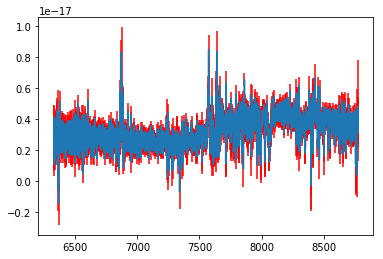

3684505476.1666403
[8174.5        8226.70019531 8168.5        8185.89990234]
[4.71078678e-18 4.84622914e-18 4.65945497e-18 4.74670309e-18]
[5.82384042e-23 5.96236592e-23 5.99248333e-23 6.07013445e-23]
[8253.09960938 8350.29980469 7656.09960938 8326.29980469]
[4.91929557e-18 5.43237006e-18 5.03138120e-18 5.23859840e-18]
[1.64693813e-20 2.03475219e-20 2.64480238e-20 6.47679097e-19]


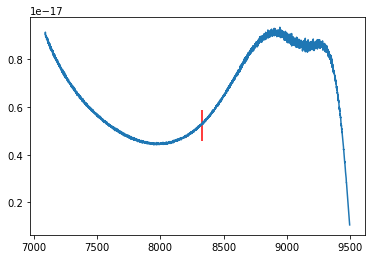

811151920.1263067
[8542.40722656 9012.45605469 9014.77636719 9012.91992188]
[4.60234025e-19 6.06528127e-19 5.85861496e-19 5.83168281e-19]
[1.29983470e-23 1.31577153e-23 1.31951344e-23 1.32753929e-23]
[9804.63574219 7914.07470703 6005.16845703 7913.62304688]
[6.37347535e-19 1.25515871e-18 1.12217702e-18 1.22589981e-18]
[3.40883838e-22 3.60994383e-22 6.07118673e-22 1.66821490e-21]


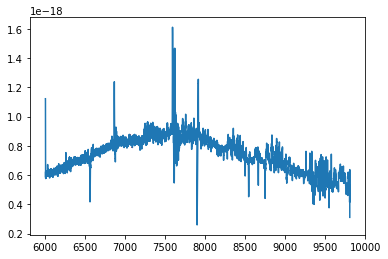

417403666.9666878
[8325.70019531 8368.90039062 8326.29980469 8174.5       ]
[3.90849826e-18 4.58280097e-18 4.76357736e-18 2.43707676e-18]
[5.82339832e-23 5.94805614e-23 6.14636503e-23 6.61962216e-23]
[8350.29980469 8152.89990234 8080.89990234 7656.09960938]
[2.57568981e-18 2.48948212e-17 3.00519846e-18 1.96354769e-16]
[1.46259694e-20 1.46887930e-20 1.84894129e-20 1.60936479e-19]


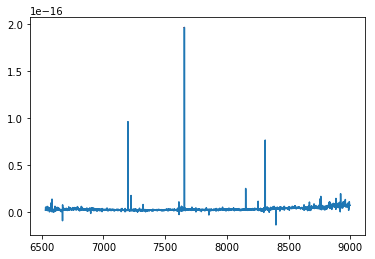

393064732.0642547
[8542.97460938 8195.98925781 8542.04101562 8515.42480469]
[6.23515969e-19 8.21174971e-19 7.21367683e-19 9.46930954e-19]
[2.81337792e-23 2.83548163e-23 2.88100695e-23 2.89355770e-23]
[9750.87011719 6336.61523438 9751.328125   9751.78710938]
[2.29365159e-18 1.65684631e-18 2.37715243e-18 2.92619229e-18]
[9.02619236e-21 2.17740438e-20 2.45917133e-20 7.49390677e-20]


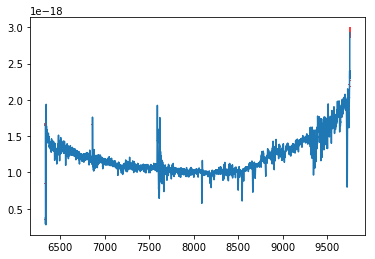

377302387.2882525
[8020.29980469 8038.89990234 8040.70019531 7638.69970703]
[2.12505070e-19 2.20486545e-19 2.21283718e-19 3.18250386e-21]
[3.12427180e-24 3.34781165e-24 3.37716451e-24 3.40418893e-24]
[8988.70019531 9100.29980469 9100.90039062 8988.09960938]
[1.41734389e-18 1.40283925e-18 1.40035866e-18 1.42274183e-18]
[6.05077091e-22 6.37846731e-22 7.21977613e-22 7.44375350e-22]


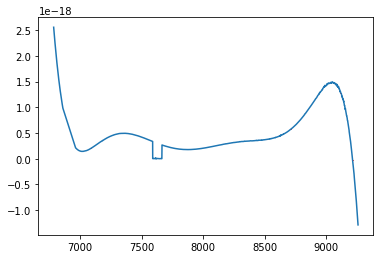

325843527.6624606
[7832.55810547 7833.9609375  7833.02539062 7957.5546875 ]
[1.68772390e-19 1.68350307e-19 1.67822321e-19 1.79341204e-19]
[6.32603708e-24 6.36133741e-24 6.46894135e-24 6.54521971e-24]
[5938.89697266 9583.68554688 9584.140625   9583.23046875]
[3.89819060e-18 5.34469136e-18 5.34623983e-18 5.41478728e-18]
[4.42549361e-20 5.26628468e-20 5.39485335e-20 5.54938382e-20]


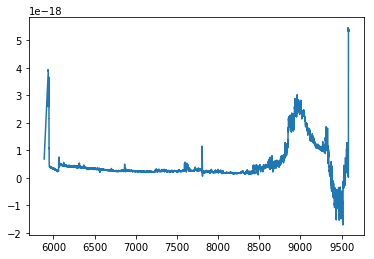

171233912.65776628
[7620.49609375 7620.98925781 9219.79296875 7620.00292969]
[2.95619311e-21 3.08478275e-21 3.17977507e-22 2.81420129e-20]
[5.97341106e-25 9.75626696e-25 1.54408994e-24 2.38597752e-24]
[5920.52246094 5921.64404297 5919.96142578 5918.83789062]
[2.62327139e-19 2.64364287e-19 2.65986945e-19 2.56214720e-19]
[3.30548955e-22 3.32489473e-22 3.35598836e-22 3.66585665e-22]


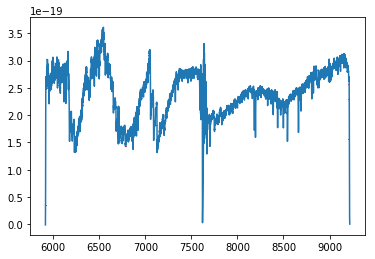

148245389.79604384
[9644.75683594 9645.66699219 9643.84667969 9545.33300781]
[5.58040448e-20 5.25355422e-20 5.53741586e-20 5.75112218e-20]
[4.98055883e-24 4.98554403e-24 5.11946834e-24 5.15631472e-24]
[7767.79833984 5854.82568359 7779.95019531 7768.27441406]
[ 1.41729821e-19  1.80614080e-19 -9.44576477e-21  1.90281698e-19]
[2.13287090e-22 2.54217865e-22 3.75469794e-22 5.68055509e-22]


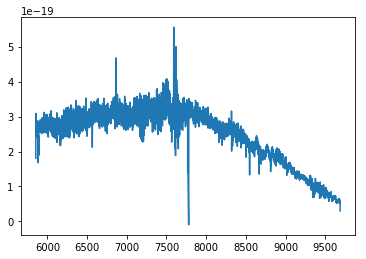

63513333.47010912
[8127.45361328 8127.91699219 8514.05859375 8514.9921875 ]
[7.82592099e-20 7.83920247e-20 1.87684219e-19 1.88356943e-19]
[1.07061775e-23 1.43506884e-23 1.47214983e-23 1.48213140e-23]
[9474.47070312 9474.92871094 9474.01269531 9473.55371094]
[2.10798234e-19 1.92323710e-19 2.39511649e-19 2.84235396e-19]
[3.52895525e-21 3.74772589e-21 3.92007574e-21 3.93850811e-21]


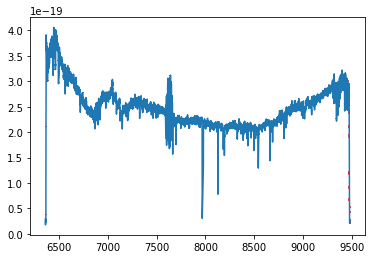

57822740.54760088
[8096.86767578 8088.29345703 8087.79931641 8097.33935547]
[1.78834676e-20 9.03782241e-21 1.94387313e-20 1.53044040e-19]
[1.58399235e-24 3.09432873e-24 3.37536128e-24 1.05762591e-23]
[9943.91210938 9945.28222656 9944.82519531 9945.73925781]
[8.62011921e-20 8.61801478e-20 8.28275303e-20 8.91237355e-20]
[3.17837347e-22 3.17940192e-22 3.23599470e-22 3.25558003e-22]


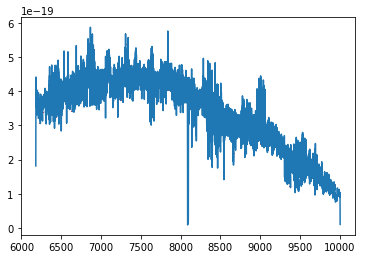

44639006.71142361
[9586.26464844 9587.62988281 9583.07910156 9586.71972656]
[1.01930891e-19 9.52501335e-20 9.91628366e-20 1.00117458e-19]
[1.40253644e-23 1.41634883e-23 1.41878979e-23 1.42695336e-23]
[6313.92871094 6313.48486328 6314.37207031 6314.81591797]
[1.23825741e-18 1.12525130e-18 1.20649238e-18 1.30040507e-18]
[2.01893510e-21 2.02533050e-21 2.05077005e-21 2.08761443e-21]


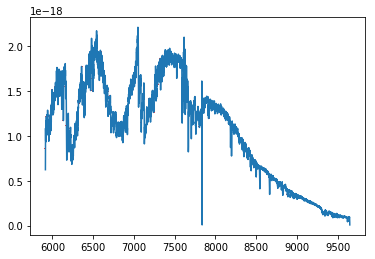

36126786.4553627
[5779.44873047 5779.90234375 5889.39111328 5889.84619141]
[-1.85349588e-19 -2.92715949e-19 -3.73024102e-19 -3.94649162e-19]
[-2.33721199e-21 -5.72473634e-22 -5.00819122e-22 -4.75539774e-22]
[9514.15136719 9472.50585938 9473.39550781 9472.95117188]
[2.46361766e-18 2.03226260e-18 2.71879745e-18 2.21694666e-18]
[6.83121081e-21 7.61514343e-21 7.62481537e-21 7.81155425e-21]


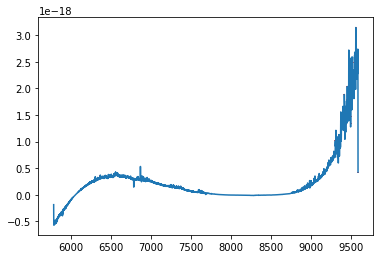

20584594.225203678
[9632.56738281 9277.64257812 9120.65722656 9121.58300781]
[1.81426112e-20 1.86722982e-19 2.34534833e-19 2.39037965e-19]
[1.92887031e-23 2.39112010e-23 2.54903615e-23 2.59798320e-23]
[5899.40087891 5900.96386719 5900.44335938 5899.92236328]
[2.93007502e-19 2.56939342e-19 2.73829822e-19 3.11305213e-19]
[1.98762911e-21 1.99430366e-21 1.99434128e-21 2.01733415e-21]


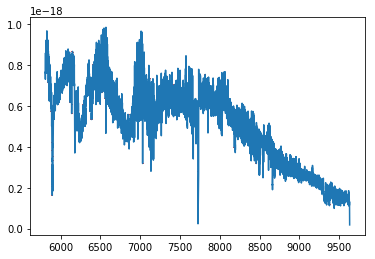

17410680.994725548
[7856.2578125  7834.54785156 7834.078125   7833.60839844]
[2.99600027e-19 9.38333076e-20 6.11279177e-20 1.33451462e-19]
[7.96779003e-23 1.23297716e-22 1.25053781e-22 1.45837139e-22]
[9380.14648438 9379.68652344 9379.2265625  9722.27929688]
[4.33311573e-18 4.25109005e-18 3.89433191e-18 4.06495065e-18]
[2.04811028e-20 2.04981377e-20 2.05239558e-20 3.35949973e-20]


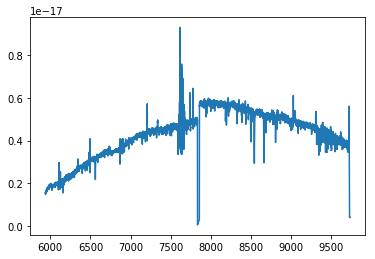

16914544.8084752
[7060.94042969 7090.33984375 7380.65478516 7081.47216797]
[1.18244052e-19 1.08420568e-19 9.55704547e-20 1.06238506e-19]
[7.40959376e-25 7.68072944e-25 7.92114595e-25 9.98483195e-25]
[9413.74609375 5770.40332031 9414.19238281 9414.63867188]
[ 1.86009606e-19 -2.16120851e-19 -1.44694986e-19  5.92131980e-19]
[7.78831733e-19 1.19344030e-18 1.67823073e-18 6.09973374e-18]


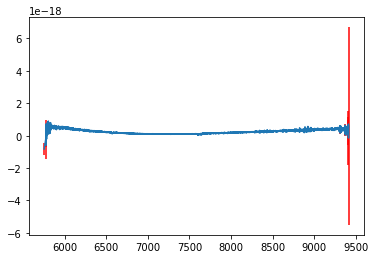

15734787.782038517
[9011.46972656 9015.69335938 9012.40820312 9117.91308594]
[6.81852108e-20 6.66679998e-20 6.99986395e-20 6.99525659e-20]
[8.37375747e-24 8.40756729e-24 8.72246265e-24 8.76791110e-24]
[7602.47558594 7601.53662109 7600.12841797 7598.25146484]
[4.43404200e-19 4.99950667e-19 5.06534116e-19 5.78997092e-19]
[8.40454567e-22 8.76610865e-22 8.77154352e-22 8.89896308e-22]


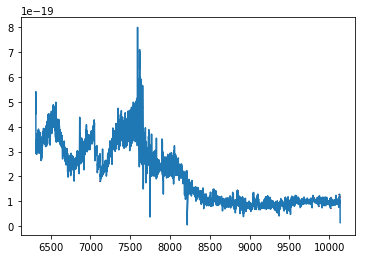

13128464.858189516
[8045.14697266 8044.22314453 8045.609375   8043.76123047]
[1.58689384e-19 1.59661901e-19 1.56718544e-19 1.76685108e-19]
[2.69651202e-23 2.70803360e-23 2.70998888e-23 2.71112040e-23]
[9791.52441406 9790.21582031 9790.65234375 9791.08789062]
[1.25535126e-18 1.07639350e-18 1.01675802e-18 1.03020435e-18]
[3.75510538e-21 3.76237362e-21 3.83130236e-21 3.84762174e-21]


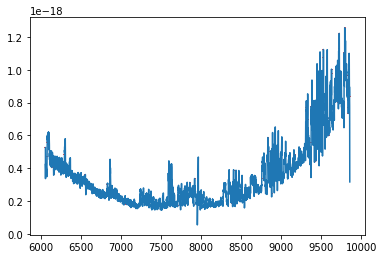

8779954.713394815
[9343.90136719 9343.44238281 9344.36035156 9344.81933594]
[3.06837112e-17 3.06892865e-17 3.33827526e-17 3.31492613e-17]
[1.01805820e-20 1.02293535e-20 1.02484291e-20 1.02681434e-20]
[9375.57128906 5890.07714844 5889.16357422 5889.62011719]
[4.24220141e-17 9.80571779e-17 8.40026269e-17 9.55028358e-17]
[4.27279406e-19 4.32480385e-19 4.45872773e-19 4.47847357e-19]


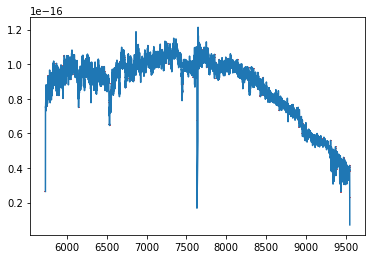

8422240.771683639
[ 8069.45166016  7647.52246094 10054.76855469  8165.98388672]
[5.15159645e-19 7.63180150e-19 4.29495254e-19 8.76172542e-19]
[1.41371648e-22 1.62084368e-22 1.63403788e-22 1.66455918e-22]
[9946.93261719 9948.31054688 9947.8515625  9947.39257812]
[1.86934549e-18 2.74754147e-18 2.07081548e-18 2.03735772e-18]
[2.94283545e-20 2.98279599e-20 2.99349827e-20 3.00136787e-20]


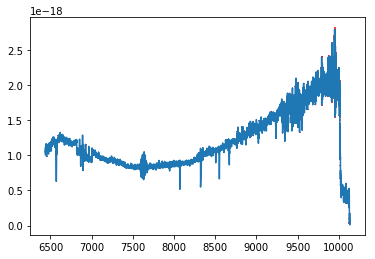

7386059.902231572
[9012.01171875 9012.93261719 9012.47265625 9013.85449219]
[2.47094603e-19 2.45982349e-19 2.46290666e-19 2.52790733e-19]
[4.89042111e-23 4.89782977e-23 4.90686230e-23 4.91845483e-23]
[9376.56445312 9382.40136719 5902.65332031 5902.13574219]
[2.00291137e-19 3.27540086e-19 1.68326616e-19 4.75849131e-19]
[2.58588615e-20 3.22512360e-20 4.02155920e-20 5.49990269e-20]


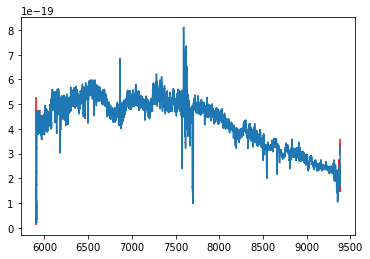

7341042.479201169
[9187.62890625 9187.16894531 9186.70996094 9186.25097656]
[-5.44967529e-20 -5.20467690e-20 -5.29450470e-20 -5.18954832e-20]
[-4.42588345e-23 -4.35289746e-23 -4.33180939e-23 -4.30300074e-23]
[8345.09863281 7914.08789062 8344.16796875 8344.63378906]
[5.21167973e-19 6.41898160e-19 5.23147374e-19 4.93148714e-19]
[2.89744689e-21 3.00249042e-21 3.05284142e-21 3.11386420e-21]


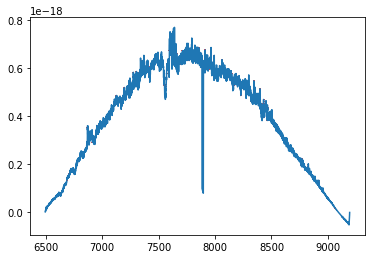

5963691.249530927
[9196.90039062 9196.29980469 9197.5        9195.70019531]
[-2.68091570e-21 -2.46702346e-21 -2.85921338e-21 -2.24801493e-21]
[-4.30121081e-24 -4.25152681e-24 -3.66995694e-24 -3.08255098e-24]
[7701.69970703 7393.29980469 8011.29980469 7485.69970703]
[4.48572761e-19 4.74263704e-19 5.33986013e-19 4.60005326e-19]
[4.88136320e-22 4.91313141e-22 5.11345001e-22 9.33104666e-22]


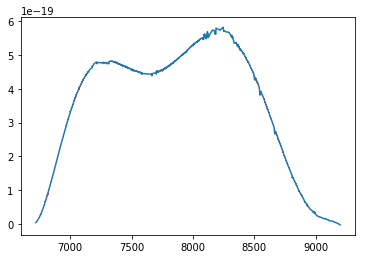

5919352.749154304
[9715.42675781 9714.98144531 9715.87207031 9716.31738281]
[-3.35664036e-20 -3.33068459e-20 -3.62673002e-20 -3.50045853e-20]
[-1.01755217e-22 -1.00274541e-22 -9.97834569e-23 -9.78596117e-23]
[6303.015625   6869.265625   6868.3359375  6868.80078125]
[8.48633485e-20 1.08588529e-19 1.06735961e-19 1.04957718e-19]
[1.97905111e-22 1.98763432e-22 2.04566279e-22 2.06067807e-22]


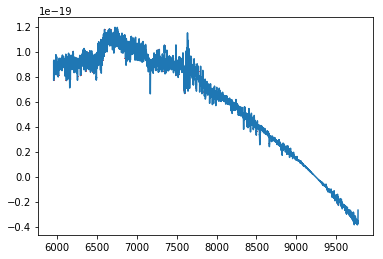

5759670.7758629965
[9344.43066406 9343.96972656 9343.50878906 9016.02832031]
[3.32401959e-17 3.30493266e-17 3.48173525e-17 5.28906392e-17]
[1.49214271e-20 1.49381030e-20 1.52022909e-20 1.54142686e-20]
[9376.69628906 9375.31445312 9376.23632812 9375.77539062]
[6.42968987e-17 6.01670456e-17 5.86359069e-17 4.27912272e-17]
[6.89217181e-19 7.05440625e-19 7.77810530e-19 7.78475680e-19]


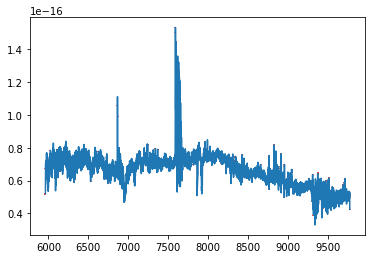

4577710.261348057
[9344.16503906 9343.70214844 9343.23925781 9344.62792969]
[1.41728940e-18 1.48214485e-18 1.37767604e-18 1.56267796e-18]
[6.79296139e-22 6.80689369e-22 6.93487333e-22 7.12119509e-22]
[9375.15625    9375.61816406 9376.08105469 7913.19091797]
[2.28912867e-18 1.95961105e-18 1.25031192e-18 3.82211017e-18]
[3.19162363e-20 3.34048005e-20 3.36013842e-20 4.02189839e-20]


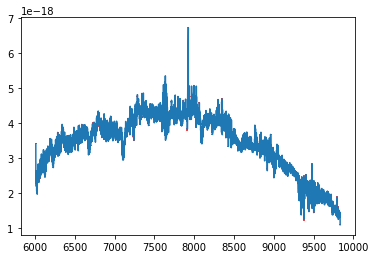

4430617.94377134
[9376.07910156 9375.61816406 9476.85742188 9376.54003906]
[-9.61739428e-19 -1.15105364e-18 -1.48350134e-18 -9.95101990e-19]
[-8.34967715e-21 -8.19158117e-21 -7.70078609e-21 -7.63083336e-21]
[7598.66699219 6299.96777344 6300.88476562 6300.42626953]
[8.35940347e-19 3.29492927e-19 3.53277348e-19 3.52952322e-19]
[1.91350273e-21 1.97500028e-21 2.00440268e-21 2.07339853e-21]


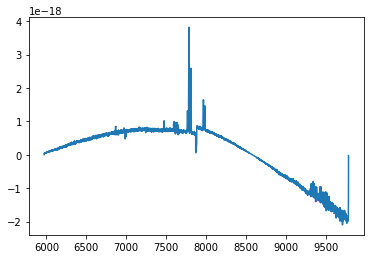

4250272.017570985
[9014.24707031 9011.93164062 9014.70996094 9015.17382812]
[6.09677539e-19 6.73001864e-19 6.26364187e-19 6.25000426e-19]
[1.84247378e-22 1.84289654e-22 1.84622538e-22 1.84996897e-22]
[7600.57373047 7602.01806641 7600.09228516 7601.53662109]
[2.05870195e-18 2.01198537e-18 2.15746756e-18 2.03947186e-18]
[6.11175911e-21 6.16137570e-21 6.54098654e-21 6.68421258e-21]


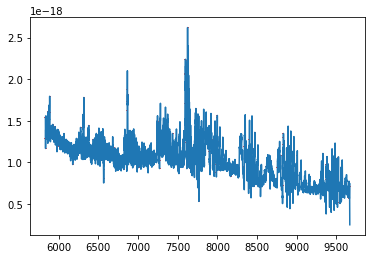

3218040.0945477495
[9946.9375     9946.48046875 9947.39453125 9946.02441406]
[-8.15081458e-19 -8.61872441e-19 -8.91891052e-19 -8.98329249e-19]
[-1.52300405e-20 -1.51729964e-20 -1.50309900e-20 -1.49937008e-20]
[7597.81054688 7598.27783203 7599.68017578 7600.14746094]
[1.59661793e-19 1.51248814e-19 1.29663952e-19 1.31820125e-19]
[2.97721452e-22 2.99781062e-22 3.09699095e-22 3.10525282e-22]


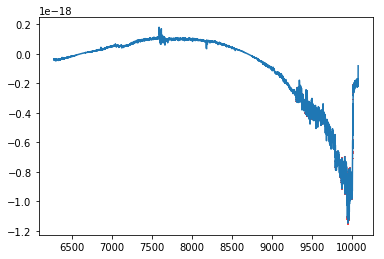

3022131.622984618
[8310.94628906 6413.63769531 8296.24121094 8582.18847656]
[1.39663306e-19 3.28547688e-19 2.39046705e-19 1.63392337e-18]
[1.28693755e-22 3.54786253e-22 3.68008007e-22 5.27128172e-22]
[10026.6875     10027.14453125 10027.6015625  10028.05957031]
[9.42514335e-18 1.72709765e-17 3.18463815e-17 1.56581295e-16]
[1.49759909e-18 2.14032475e-18 4.51693787e-18 5.38029311e-17]


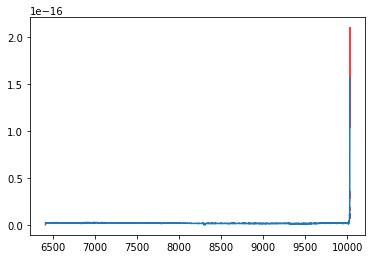

2655868.3433847204
[7631.38720703 7595.95410156 7638.38183594 7641.17919922]
[1.25500734e-17 1.39818259e-17 1.11957483e-17 1.01932431e-17]
[9.73389519e-23 1.53340077e-21 1.59116130e-21 1.84124971e-21]
[9322.66015625 9323.11816406 6354.05761719 6353.60205078]
[ 1.04693762e-17  4.73068177e-18 -3.55712536e-17  7.59762907e-17]
[2.44767467e-16 2.52674605e-16 2.91328477e-16 7.77967756e-16]


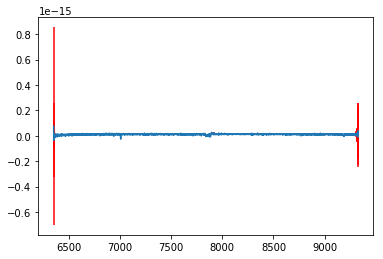

2407071.2602667864
[7614.890625   7614.42333984 7643.84228516 7669.98291016]
[7.85215790e-20 7.79473017e-20 1.00247109e-19 1.22193892e-19]
[4.40907228e-23 4.44909162e-23 4.62608639e-23 4.66804383e-23]
[8958.015625   8958.47363281 8958.93261719 8959.39160156]
[1.61184258e-19 1.59358897e-19 1.33016795e-19 2.05212415e-19]
[1.57148443e-20 1.71173989e-20 3.04232771e-20 2.66490701e-19]


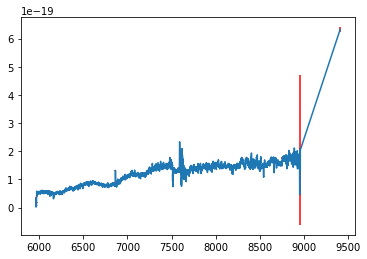

2062794.213081905
[10139.953125    8223.51855469  8236.53222656 10139.49707031]
[9.89008992e-19 4.85134880e-18 1.74619672e-17 6.16487149e-18]
[2.75167904e-21 3.60196075e-21 7.38457953e-21 7.61406373e-21]
[9872.25878906 9915.39160156 9914.47460938 9914.93359375]
[5.88879576e-17 9.85840021e-17 7.18022438e-17 7.39245245e-17]
[3.99273639e-18 4.02712088e-18 4.45988579e-18 4.52232425e-18]


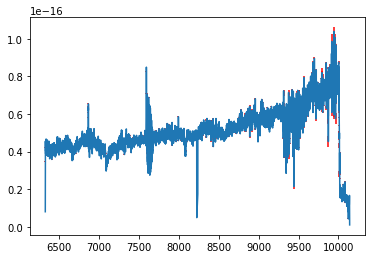

1941354.8409705148
[9330.11132812 9330.57128906 9329.65234375 9329.19238281]
[-2.64364179e-19 -4.40888705e-19 -1.74269561e-19 -1.69789412e-19]
[-1.04594019e-20 -1.01785264e-20 -1.01616968e-20 -9.02596967e-21]
[6295.95263672 6294.5859375  6296.86328125 6296.40771484]
[ 9.90720352e-21 -1.48897745e-20 -7.35551007e-21 -1.33266499e-20]
[2.84421606e-21 2.94420932e-21 3.26357997e-21 3.39948901e-21]


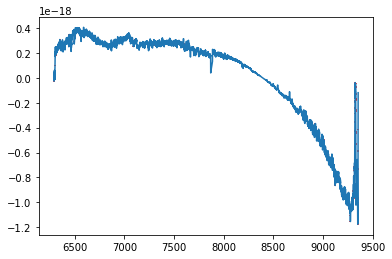

1692566.2071425824
[8260.2265625  8248.67382812 8260.69921875 8248.20214844]
[1.17298139e-17 2.29110014e-17 6.43520035e-17 8.76852057e-17]
[4.98924042e-21 2.26161447e-20 2.90772631e-20 6.00799488e-20]
[10026.71777344 10027.17578125 10027.6328125  10028.08984375]
[1.23265119e-15 2.02171769e-15 3.14841206e-15 1.79263850e-14]
[7.35122459e-17 1.10907400e-16 2.70135982e-16 5.25600074e-15]


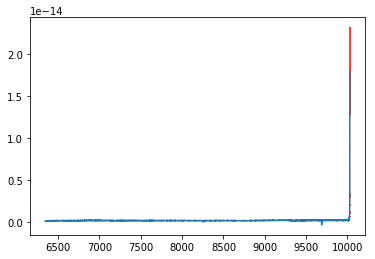

1497486.741212693
[9541.35839844 7646.8671875  7632.50341797 8722.36035156]
[4.12328753e-20 2.09658633e-19 9.53276374e-20 4.30776744e-19]
[6.66105886e-23 1.08200312e-22 1.63846906e-22 2.12514622e-22]
[9374.83789062 9373.48828125 9374.38769531 9373.93847656]
[2.88286667e-19 6.97279394e-19 2.94296357e-19 3.66754431e-19]
[1.44857689e-20 1.62918077e-20 1.65583422e-20 1.70631264e-20]


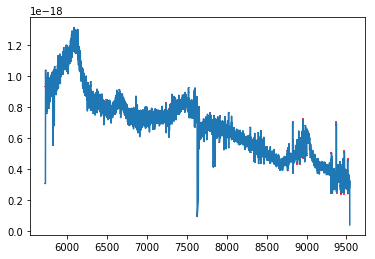

1311340.7257163718
[9016.72753906 9017.18652344 9016.26757812 9015.80859375]
[1.94160250e-17 2.03647867e-17 1.97244604e-17 2.06363287e-17]
[1.27901613e-20 1.28556627e-20 1.29303242e-20 1.31036323e-20]
[5884.11376953 5883.66015625 5883.20654297 5882.75244141]
[-1.41398224e-17 -4.39334374e-18 -2.15498023e-19  4.98505156e-18]
[3.21543702e-18 3.35810993e-18 6.70864051e-18 1.95780426e-17]


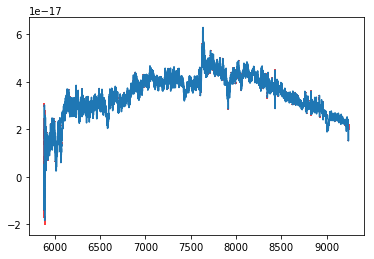

1253156.94213052
[6954.09960938 6953.5        6952.89990234 6954.69970703]
[3.61649674e-18 3.62263569e-18 3.62127484e-18 3.61885861e-18]
[2.49144718e-21 2.50323745e-21 2.52311995e-21 2.52362132e-21]
[8014.89990234 8025.09960938 8164.29980469 8165.5       ]
[5.74731927e-18 5.73293220e-18 5.71729851e-18 5.71145667e-18]
[4.38860939e-20 5.60767598e-20 8.23764758e-20 8.33948575e-20]


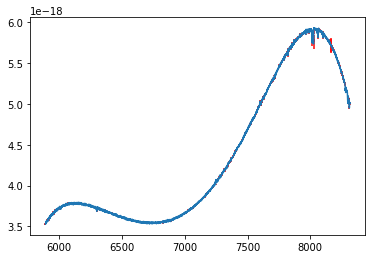

1111036.4307181071
[7955.72753906 7955.26171875 7954.79541016 7956.65966797]
[4.74705269e-17 4.73797529e-17 4.55972995e-17 4.93341244e-17]
[3.59407178e-20 3.60040311e-20 3.61027145e-20 3.63653532e-20]
[9050.43261719 9051.80859375 6190.00878906 6189.55224609]
[1.03908537e-16 7.83477279e-17 1.44885834e-16 1.20401984e-16]
[1.38316661e-17 2.20396894e-17 2.30189312e-17 1.13977593e-16]


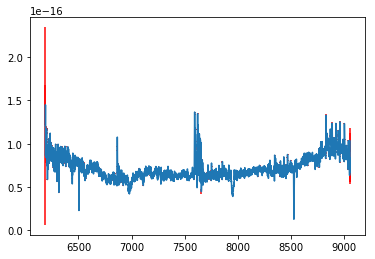

1093927.4797339805
[9807.97070312 9775.23144531 9774.32128906 9774.77636719]
[5.94429967e-19 5.04855923e-18 4.83921169e-18 4.83850316e-18]
[2.44367985e-21 7.62139856e-21 7.66191970e-21 7.66344823e-21]
[6301.09912109 6299.72265625 6300.18115234 6300.64013672]
[4.82399824e-17 3.61616395e-17 5.60983450e-17 4.16243260e-17]
[8.08549323e-19 8.50694100e-19 8.84785159e-19 8.86865243e-19]


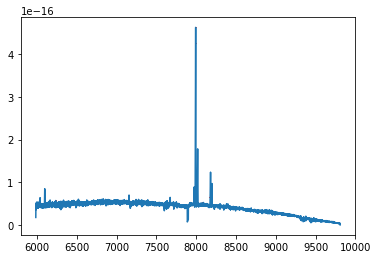

1051128.2003469137
[9777.91308594 9778.40722656 9780.8828125  9776.92382812]
[1.15549771e-20 1.16368962e-20 1.17200792e-20 1.24450958e-20]
[1.67551688e-23 1.67625584e-23 1.67641167e-23 1.67820938e-23]
[6304.50390625 6304.04443359 6303.12548828 7603.13574219]
[1.18193102e-19 1.21694861e-19 1.31780296e-19 1.39747444e-19]
[6.04443725e-22 6.04802648e-22 6.14653940e-22 6.25405941e-22]


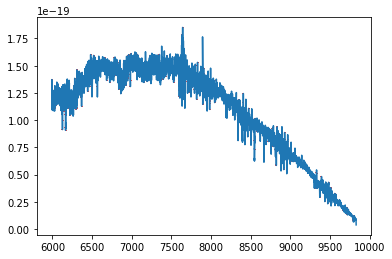

932432.9983399316
[9016.01757812 9016.94824219 9016.48242188 9015.55175781]
[2.24911457e-17 2.17548671e-17 2.26769076e-17 2.28916823e-17]
[1.44178075e-20 1.44472823e-20 1.44679704e-20 1.46037778e-20]
[9375.921875   7836.11523438 9743.34570312 5915.08203125]
[2.12290897e-17 5.12216202e-17 3.68846919e-18 1.79473637e-17]
[6.32462068e-19 8.76714858e-19 9.60105745e-19 5.34217359e-18]


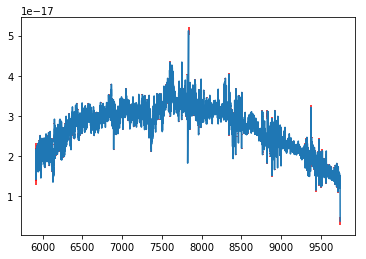

766603.0704632811
[8116.89990234 8117.5        8088.09960938 8089.29980469]
[7.13319570e-18 7.11480814e-18 7.16601131e-18 7.13299229e-18]
[5.67689947e-21 5.76599551e-21 5.81486237e-21 5.81866851e-21]
[8778.09960938 9002.5        9001.90039062 9001.29980469]
[8.33366509e-18 8.79964917e-18 8.81822722e-18 8.80687929e-18]
[5.68285014e-20 7.68125541e-20 1.01238748e-19 1.12562518e-19]


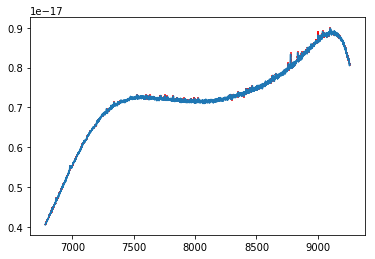

759957.7959361934
[8044.87744141 8055.60400391 8037.41552734 8090.58740234]
[1.06853976e-16 1.11556175e-16 1.12412607e-16 1.09318990e-16]
[9.13978100e-20 9.18299942e-20 9.21471222e-20 9.21814814e-20]
[6395.23486328 6394.77880859 9248.70214844 6394.32275391]
[3.90059504e-16 3.83947780e-16 4.60318841e-16 2.70340313e-16]
[8.67964572e-17 8.82389024e-17 1.27868822e-16 3.27883833e-16]


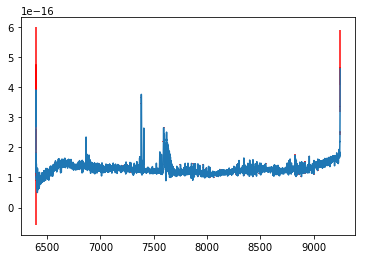

646870.7926068613
[8173.71044922 8185.70703125 8173.23828125 8186.17871094]
[6.45437594e-18 2.95175225e-17 2.27028454e-17 5.22469178e-17]
[9.35431348e-21 1.67952368e-20 2.34947619e-20 3.63221231e-20]
[10012.515625   10081.18457031 10082.09277344 10081.63867188]
[8.57072821e-17 1.04364880e-16 6.41216338e-17 1.20091996e-16]
[2.10156041e-17 2.16726861e-17 2.27939770e-17 2.31748364e-17]


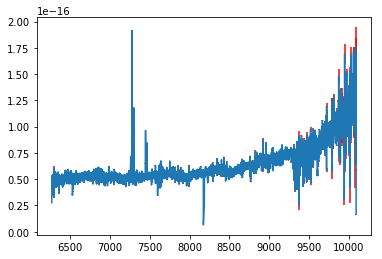

625868.3066027839
[7875.69921875 7884.54882812 6453.98974609 7875.23583984]
[4.29808586e-18 1.65191632e-17 5.11748465e-20 1.30020066e-17]
[6.06388296e-21 1.02986410e-20 1.13188844e-20 1.30705131e-20]
[8827.65722656 8826.27050781 8827.1953125  8826.73242188]
[5.60705029e-17 5.92593181e-17 5.08284128e-17 5.71993820e-17]
[1.38480040e-18 1.38726759e-18 1.46966364e-18 1.50500244e-18]


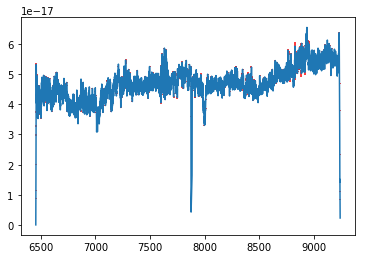

594497.7717567672
[9556.08300781 7658.29785156 9555.64550781 5744.18164062]
[4.32831166e-19 7.44841674e-18 9.45782959e-18 6.22351172e-18]
[3.31413499e-21 6.73031790e-21 1.95706344e-20 2.84802289e-20]
[9374.75585938 9373.40332031 9374.3046875  9373.85351562]
[5.27349926e-17 7.31041796e-17 5.64027338e-17 4.20208714e-17]
[1.45552609e-18 1.52398775e-18 1.59636695e-18 1.61184754e-18]


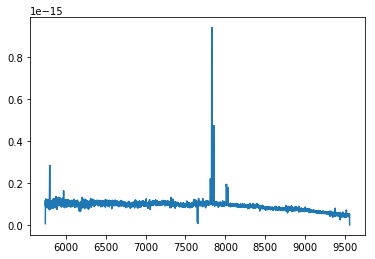

568062.942753239
[8042.20800781 8054.11767578 8054.58837891 8041.73730469]
[7.34777379e-19 4.57114503e-18 1.21187391e-17 9.24393177e-18]
[2.49408689e-21 3.74195143e-21 8.64153965e-21 8.74675677e-21]
[9871.92871094 9915.22363281 9914.3125     9914.76757812]
[1.32817587e-17 1.55087106e-17 1.86229498e-17 1.71675356e-17]
[1.13559747e-18 1.16244576e-18 1.27295711e-18 1.28971453e-18]


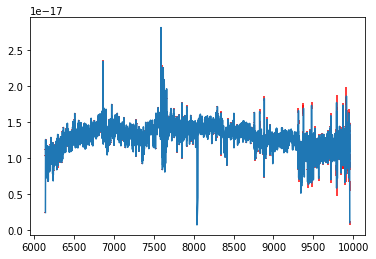

533868.0326270646
[8561.11132812 8560.64453125 8563.91308594 8564.37988281]
[5.29242779e-18 4.87280676e-18 5.14130257e-18 5.13888952e-18]
[3.81705109e-21 3.83110244e-21 3.83215218e-21 3.83622646e-21]
[9376.81640625 9375.44335938 9376.35839844 9375.90136719]
[3.61420468e-18 4.91036587e-18 4.70515648e-18 6.13764007e-18]
[2.49901368e-19 2.74469382e-19 2.78594909e-19 2.83999377e-19]


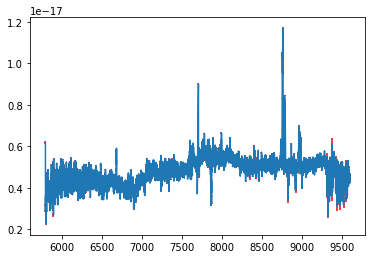

475745.14088233
[9343.953125   9344.41308594 9343.49316406 9344.87304688]
[3.50563909e-17 3.24743151e-17 3.45213773e-17 3.52468811e-17]
[4.66168478e-20 4.78648854e-20 4.82016774e-20 4.96302435e-20]
[6300.81347656 6299.89599609 6300.35498047 5917.49609375]
[8.57939389e-17 8.90511376e-17 1.11227678e-16 2.33760018e-16]
[2.26042595e-18 2.34796542e-18 2.38210649e-18 3.51784011e-18]


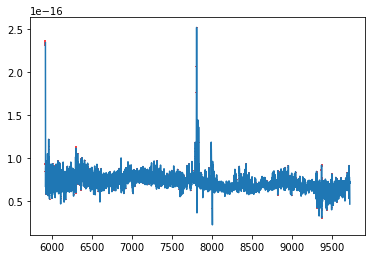

467357.41003438726
[6925.89990234 6925.29980469 6926.5        6915.09960938]
[9.96840004e-21 9.89885773e-21 1.00621919e-20 9.98334641e-21]
[9.03885140e-24 9.06470914e-24 9.06976686e-24 9.11838215e-24]
[8036.5        8080.29980469 8058.09960938 8037.09960938]
[4.20779456e-19 4.40722475e-19 4.35870132e-19 4.26180175e-19]
[3.55368134e-21 3.59151380e-21 3.64331000e-21 4.37331290e-21]


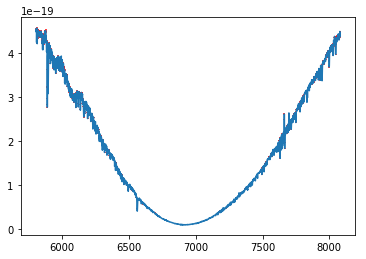

412507.62583999435
[8654.5        8644.90039062 8691.09960938 8706.70019531]
[-8.93540734e-20 -9.75002379e-20 -9.30805021e-20 -9.96315339e-20]
[-3.99891290e-22 -3.99758117e-22 -3.92930174e-22 -3.86363955e-22]
[7820.5        7759.29980469 7717.29980469 7913.5       ]
[1.57982948e-19 1.62759306e-19 1.56438591e-19 1.46593147e-19]
[6.25657279e-22 6.27451757e-22 6.28403572e-22 6.44350019e-22]


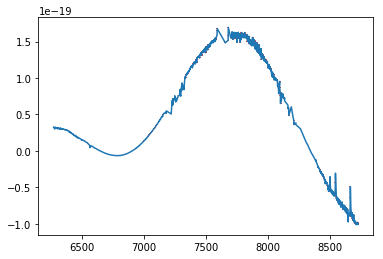

375965.2932404861
[7194.69970703 7188.09960938 7173.69970703 7177.29980469]
[2.58625724e-19 2.56209404e-19 2.63088397e-19 2.62119029e-19]
[1.88121944e-22 2.08583655e-22 2.20400574e-22 2.25798526e-22]
[8848.90039062 8851.29980469 8850.70019531 8850.09960938]
[2.66066072e-19 2.66532668e-19 2.67359807e-19 2.66510765e-19]
[6.85611344e-21 8.85295467e-21 9.33187690e-21 9.49349490e-21]


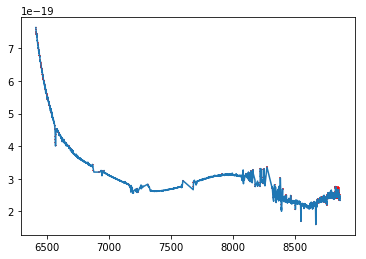

355421.7882002466
[8168.11572266 8164.80859375 8174.72949219 8167.17041016]
[1.80262445e-17 1.75027372e-17 1.93453482e-17 1.87028964e-17]
[1.92594788e-20 1.93847945e-20 1.93965527e-20 1.94092279e-20]
[10028.97265625 10029.42871094 10029.88574219 10030.34179688]
[ 1.37014409e-16  2.84694467e-16  4.88478927e-16 -1.39425906e-14]
[2.99210030e-17 6.47034601e-17 2.95665221e-16 1.68024314e-13]


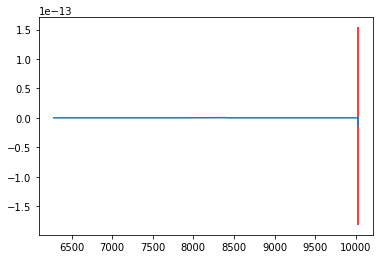

329216.8415194773
[8185.02978516 8171.84814453 8185.49853516 8171.37939453]
[3.81830106e-18 5.79821938e-18 4.45443661e-17 4.16600486e-17]
[5.49854718e-21 9.54988329e-21 4.98474729e-20 5.09691649e-20]
[9947.11425781 9914.74121094 9946.65820312 9915.19726562]
[7.04555876e-17 6.19838657e-17 1.14977177e-16 8.06547149e-17]
[4.59087069e-18 4.69190893e-18 4.74161168e-18 4.75985510e-18]


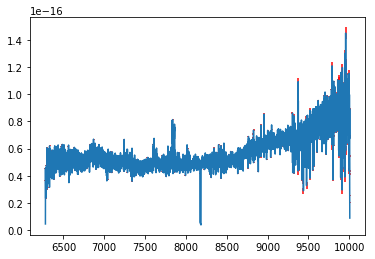

325346.9135083577
[7769.56201172 7761.64208984 9670.29296875 5856.12939453]
[7.51965262e-18 2.77672778e-18 2.93063385e-18 1.87869790e-18]
[9.43134263e-21 1.62784547e-20 2.77699086e-20 3.32749277e-20]
[9374.97753906 9376.35351562 9375.43652344 9375.89453125]
[6.81990076e-17 1.02957245e-16 4.44749820e-17 6.70535708e-17]
[6.24101199e-18 7.22799556e-18 7.31490763e-18 7.59111761e-18]


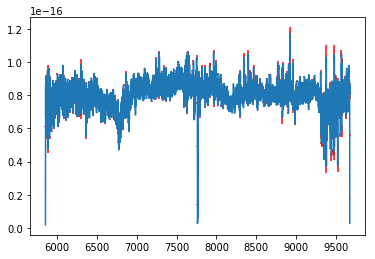

309270.1976722775
[7899.96826172 7888.36181641 7900.43554688 8119.953125  ]
[6.17623060e-18 4.87914692e-18 3.89907695e-17 3.88211193e-17]
[7.14384222e-21 2.29238045e-20 4.99580740e-20 5.24449730e-20]
[9322.00097656 9322.45898438 9323.37402344 9322.91699219]
[7.20271343e-17 7.57751931e-17 7.79877414e-17 9.21953561e-17]
[2.68557796e-17 3.43689891e-17 3.65852898e-17 3.75741680e-17]


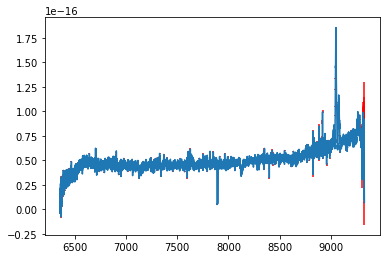

300367.0703677728
[9344.02734375 9344.48632812 9343.56835938 9343.109375  ]
[2.88912588e-17 2.76596280e-17 2.75022988e-17 3.06481960e-17]
[5.18158502e-20 5.25166984e-20 5.27686460e-20 5.56825849e-20]
[6300.32226562 5889.52001953 5889.97607422 5731.65625   ]
[9.67863581e-17 7.48020769e-18 1.00548928e-16 1.84011934e-16]
[3.41797275e-18 3.58527886e-18 3.72162643e-18 5.62933870e-18]


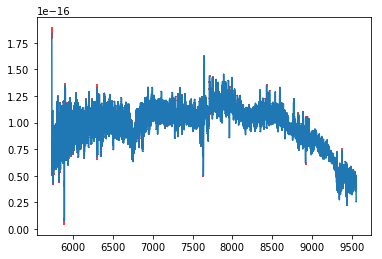

207467.3967433788
[8932. 8858. 8934. 8860.]
[4.64610377e-21 7.88164333e-21 2.20769997e-21 5.12795936e-21]
[4.65883649e-21 4.66439790e-21 4.67097792e-21 4.68957531e-21]
[5778. 5762. 7602. 6738.]
[ 2.31148101e-17 -1.11787553e-17  1.17359503e-16 -3.24499824e-25]
[1.01337100e-19 1.10568557e-19 1.15240041e-19 8.13305754e-19]


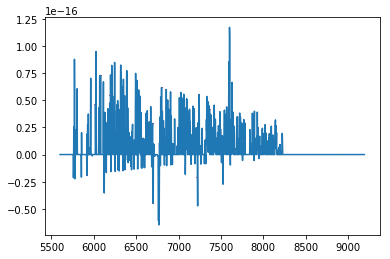

206539.07543260616
[9016.65136719 9016.18945312 9015.7265625  9017.11425781]
[4.02709284e-18 4.22699557e-18 3.83553848e-18 3.97311656e-18]
[5.40420665e-21 5.44420124e-21 5.46846984e-21 5.48201197e-21]
[5890.61572266 5889.70703125 5890.16162109 5799.44189453]
[6.33549434e-18 3.64646933e-18 6.31370370e-18 5.12548144e-18]
[3.59868477e-19 3.77084157e-19 3.80419727e-19 2.07263298e-18]


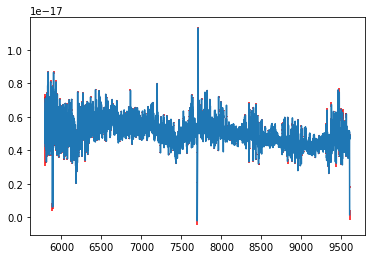

203302.0719875509
[8082.04589844 8087.68164062 6185.44189453 8088.15234375]
[1.79643963e-19 2.74033445e-19 3.39661469e-20 3.48443810e-19]
[2.66862645e-22 3.25239660e-22 3.60935462e-22 4.20363943e-22]
[9722.65039062 9723.56933594 9723.11035156 9724.02832031]
[2.41891143e-18 1.73314301e-18 2.03813234e-18 1.89227972e-18]
[5.89184926e-20 5.91046721e-20 5.95112466e-20 6.01301936e-20]


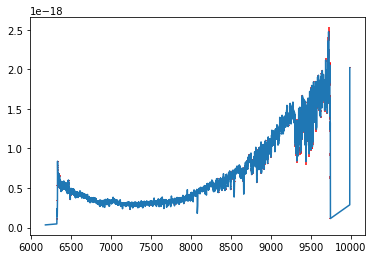

190853.62651242423
[9016.23144531 9017.16894531 9016.70019531 9017.63769531]
[7.03378505e-18 7.23461159e-18 7.62343869e-18 7.34180281e-18]
[9.62707057e-21 9.64034940e-21 9.66558846e-21 9.77522874e-21]
[10083.47070312 10082.55859375 10083.01464844 10086.20703125]
[8.82922541e-18 4.65683497e-18 1.75926642e-18 1.70874250e-17]
[5.19494312e-18 5.33423324e-18 5.58078041e-18 7.08141980e-18]


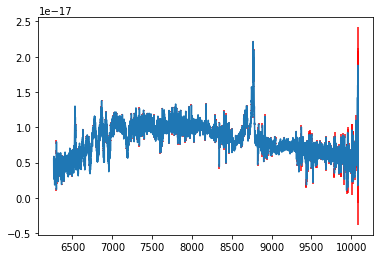

188530.3075606443
[9791.08984375 9790.6328125  9791.54589844 9790.17675781]
[-2.48319475e-20 -1.54971762e-20 -1.31014877e-20 -1.86182604e-20]
[-4.34135045e-21 -4.08582862e-21 -4.05767141e-21 -3.72736277e-21]
[8344.46484375 8826.74511719 8827.68164062 8827.21386719]
[4.54527025e-19 4.14837379e-19 2.05765321e-19 3.21406216e-19]
[1.78659755e-20 1.86117154e-20 1.90356675e-20 2.09293306e-20]


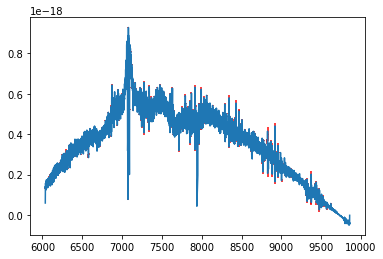

168409.4493932994
[10053.21777344 10053.67480469 10054.58691406 10055.04394531]
[2.30720876e-18 2.14307187e-18 2.29548336e-18 2.39249821e-18]
[4.91715601e-22 4.97604407e-22 5.07943435e-22 5.11525422e-22]
[9476.82617188 9375.203125   9376.13183594 9375.66699219]
[1.60322776e-17 2.43399617e-17 1.56698986e-17 6.79885085e-18]
[2.11479199e-18 2.26242083e-18 2.47182426e-18 2.53731724e-18]


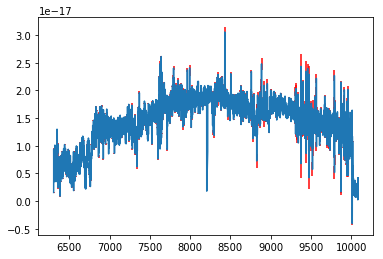

165572.5170229529
[10280.71484375 10279.80175781 10280.2578125  10279.34472656]
[1.75196630e-18 1.66624472e-18 2.15895446e-18 1.62458475e-18]
[3.42930441e-21 3.43879393e-21 3.44821556e-21 3.45993222e-21]
[10171.89453125 10173.26757812 10172.35253906 10172.81054688]
[1.98631598e-17 3.91157785e-17 7.00308500e-17 4.83333659e-17]
[3.51377919e-17 3.78734915e-17 4.04771309e-17 4.18283766e-17]


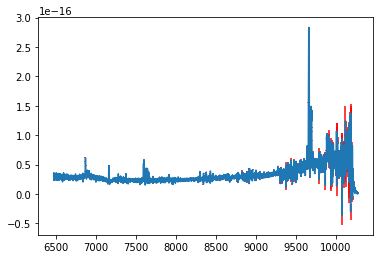

161652.45002085992
[8557.64746094 8558.57714844 8556.71875    8558.11230469]
[2.01162614e-17 1.98042466e-17 2.02811672e-17 2.01939699e-17]
[2.66735036e-20 2.67479033e-20 2.68385128e-20 2.69228425e-20]
[9299.28027344 5897.47705078 9299.73632812 5897.00585938]
[ 1.64798560e-17  1.50238024e-18  1.85032913e-17 -3.76450827e-18]
[4.15507000e-18 1.34791481e-17 1.49635882e-17 7.96217721e-17]


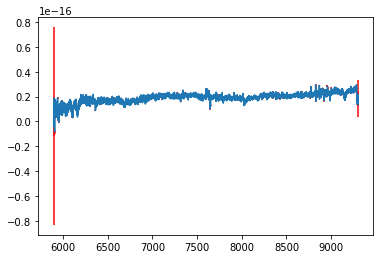

152913.77259601204
[10083.97070312  8168.42578125  8179.45019531 10083.51660156]
[-7.42325039e-21  1.78597824e-21  1.45609668e-19 -4.26927110e-22]
[2.05334273e-23 7.49708844e-23 1.31327011e-22 1.47662524e-22]
[10011.29101562 10011.74609375 10012.65527344 10012.20019531]
[1.79522012e-18 2.20716447e-18 1.51484790e-18 1.31052113e-18]
[4.58372797e-19 5.21114826e-19 5.23276957e-19 5.47728326e-19]


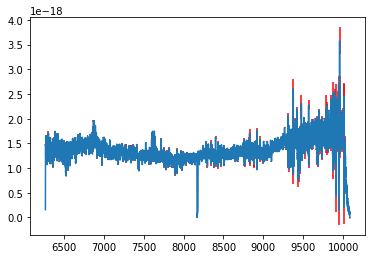

151882.4224919159
[6130.44628906 8042.39404297 8030.46142578 8042.86523438]
[2.97318292e-20 2.56068493e-19 7.06830768e-20 6.83478244e-19]
[2.79317913e-22 3.88681956e-22 4.84462105e-22 8.29320485e-22]
[9872.23046875 9914.171875   9915.08300781 9914.62695312]
[5.51559509e-19 6.80195973e-19 6.73542653e-19 9.27866850e-19]
[1.23752338e-19 1.30983603e-19 1.34432199e-19 1.38954721e-19]


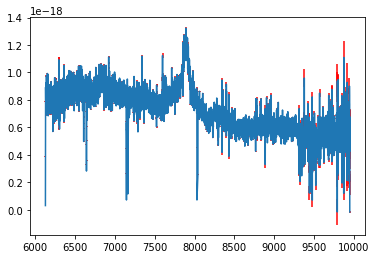

149067.75854422347
[8155.29980469 8047.29980469 8112.09960938 8046.70019531]
[3.70526845e-19 3.92087205e-19 4.01610769e-19 4.03904000e-19]
[6.02843182e-22 6.22375405e-22 6.26331718e-22 6.30014251e-22]
[6236.5        6904.89990234 8176.89990234 7595.5       ]
[6.24212340e-19 7.50876601e-19 6.23623795e-19 7.46549876e-19]
[2.52919867e-21 2.66679241e-21 2.66750558e-21 3.06252954e-21]


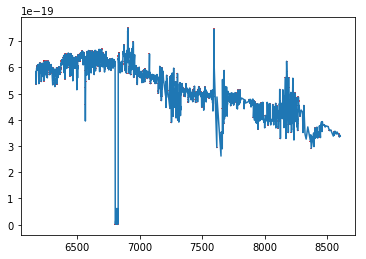

147587.3980068114
[9375.81152344 9477.16796875 9476.71191406 9376.26855469]
[-1.29266327e-18 -4.35388258e-19 -6.35666873e-19 -6.90312855e-19]
[-1.29202317e-19 -1.28727159e-19 -1.27250208e-19 -1.24560744e-19]
[6261.41210938 6262.79248047 6262.33203125 6261.87207031]
[9.44859120e-18 7.45087617e-18 9.63651888e-18 9.72279748e-18]
[3.46489355e-20 3.56423204e-20 4.31787169e-20 5.02416273e-20]


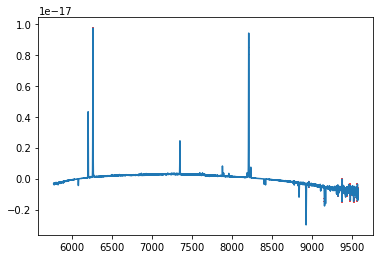

139881.9662295154
[9451.60058594 9451.15625    9452.04492188 9452.48925781]
[-7.47764819e-20 -1.02137605e-19 -3.83575919e-20 -2.79702891e-20]
[-2.23528062e-20 -2.19552713e-20 -2.09093290e-20 -1.59497330e-20]
[5893.81835938 5893.34570312 5894.76269531 5894.29052734]
[-8.07603040e-21 -3.44417653e-21  2.44019287e-20 -3.27388450e-20]
[9.04727467e-21 9.28719777e-21 1.02443974e-20 1.17505040e-20]


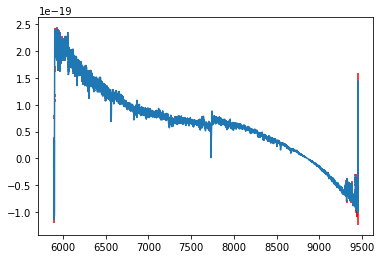

125651.90993757517
[8049.55322266 8040.69384766 8050.02197266 8040.22509766]
[2.55650246e-18 1.04895473e-17 1.42422251e-17 2.30363278e-17]
[5.76566915e-21 1.16871496e-20 3.24275375e-20 3.52246928e-20]
[9791.46777344 9790.55566406 9913.39941406 9791.01171875]
[-9.75007426e-18  1.04580415e-16  7.10073979e-18  1.29991259e-16]
[7.15809392e-18 7.26586673e-18 7.47865245e-18 7.65924754e-18]


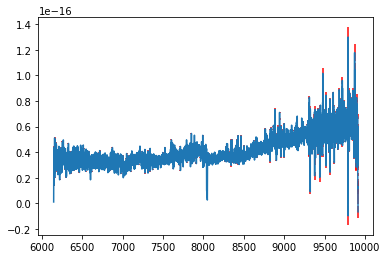

115563.56246000234
[10222.578125   10222.125      10221.67089844 10221.21777344]
[ 3.98841775e-22 -3.05914723e-21  7.47846169e-22  2.03923766e-21]
[2.58945540e-25 4.54695885e-25 4.78592433e-25 7.32550657e-25]
[10013.19433594  9914.37402344 10012.28027344 10012.73730469]
[2.10646232e-17 7.33962141e-18 9.65825253e-18 1.08607622e-16]
[4.45904193e-17 4.48426209e-17 4.95238592e-17 4.98899646e-17]


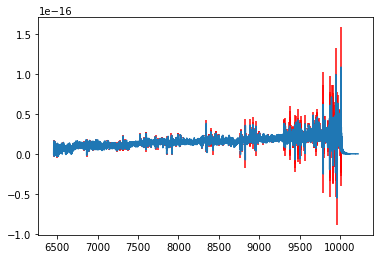

114804.33472589366
[9914.92382812 9914.46777344 9946.42871094 9945.97265625]
[-1.67160085e-17 -3.39745748e-17 -3.13432613e-17 -2.04060527e-17]
[-4.85420104e-18 -4.78466966e-18 -4.70509522e-18 -4.62931442e-18]
[7276.59472656 7275.19287109 7276.12744141 7275.66015625]
[4.14760910e-17 3.24346768e-17 2.78835020e-17 3.80197875e-17]
[3.53239913e-18 3.57942009e-18 3.79152567e-18 3.81327197e-18]


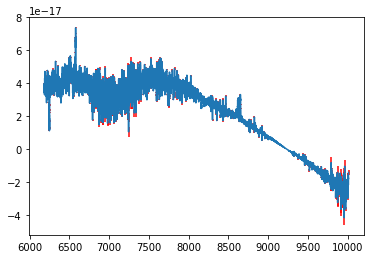

110981.59742769026
[6067.89990234 6082.29980469 6082.89990234 6085.29980469]
[1.14057178e-18 1.14856668e-18 1.15054266e-18 1.15323465e-18]
[1.96759272e-21 1.97054672e-21 1.97076326e-21 1.97294525e-21]
[7597.29980469 7276.29980469 7717.89990234 7597.89990234]
[2.17558857e-18 1.99207328e-18 2.24747794e-18 2.15468561e-18]
[1.00607491e-20 1.01194857e-20 1.01881582e-20 1.05708125e-20]


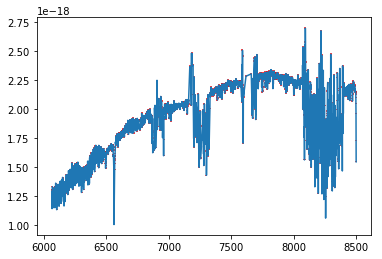

106145.08056010336
[8513.85644531 8563.70117188 8562.76953125 8563.23535156]
[1.69474597e-19 2.32957921e-19 2.54006090e-19 2.44370413e-19]
[3.04577263e-22 3.07636319e-22 3.09656211e-22 3.11896603e-22]
[9510.01855469 9508.67578125 9510.46582031 9509.5703125 ]
[9.04447977e-19 2.39298489e-18 4.81513220e-19 1.48231531e-18]
[5.03940524e-19 5.05197785e-19 5.07074995e-19 5.15933473e-19]


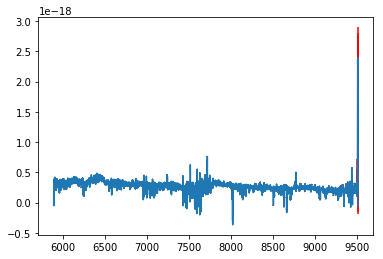

89410.76939728745
[8514.20410156 8515.61523438 8513.73339844 8516.0859375 ]
[1.54833470e-17 1.70690972e-17 1.48938535e-17 1.57103671e-17]
[2.78736076e-20 2.83184676e-20 2.83602056e-20 2.84293720e-20]
[10171.47558594 10172.38769531 10171.93164062 10179.68261719]
[ 6.83174034e-17 -1.95153774e-18 -5.00511641e-17  1.61148449e-18]
[2.28828306e-17 2.39753391e-17 2.48782152e-17 1.07972283e-16]


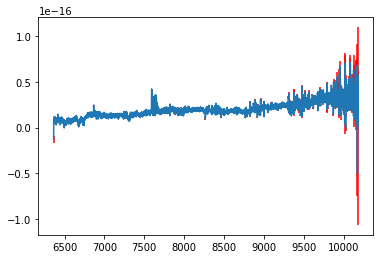

86751.51893979558
[10162.75       10162.29589844 10139.12402344 10138.66992188]
[3.11124999e-20 1.18535523e-19 1.78548765e-19 2.51301432e-19]
[6.22124001e-22 1.46986883e-21 1.59490232e-21 1.59816695e-21]
[9375.0625     9376.45996094 9375.52832031 9375.99414062]
[7.56594351e-18 4.05456980e-18 5.08731794e-18 3.69816401e-18]
[8.26421237e-19 8.84548989e-19 9.52955237e-19 9.70935129e-19]


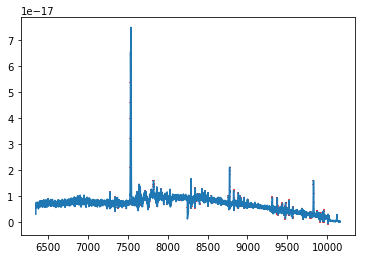

85654.0537527431
[ 8329.71679688 10243.25976562 10242.34863281 10242.8046875 ]
[ 1.56732776e-18  1.49649788e-18 -5.50293623e-19  1.97098949e-18]
[4.05795862e-21 9.35402834e-21 1.04192300e-20 1.04882316e-20]
[9946.40234375 9915.15332031 9914.234375   9914.69335938]
[2.23757991e-17 1.72326607e-18 1.28275506e-17 4.44046381e-18]
[5.65452466e-18 6.04385245e-18 6.05441919e-18 6.40628659e-18]


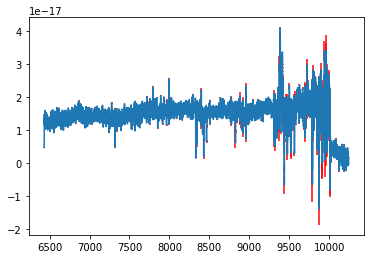

84331.98975046277
[8040.59277344 8041.07763672 8038.65087891 8039.13671875]
[9.17838586e-20 9.23489133e-20 9.13347932e-20 9.20138746e-20]
[1.56208008e-22 1.56416571e-22 1.57204998e-22 1.57348200e-22]
[9505.3046875  9508.05664062 6387.61279297 9508.515625  ]
[3.22687210e-19 3.72577832e-19 6.82826681e-20 4.39599584e-19]
[4.96694410e-20 5.88802538e-20 1.05962877e-19 1.68541077e-19]


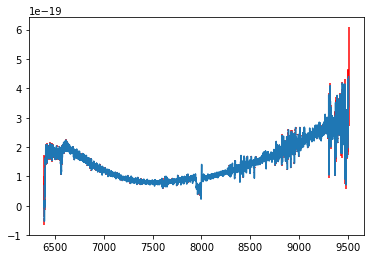

83543.42342263162
[9016.70996094 9016.24316406 9015.77734375 9015.31152344]
[1.94385855e-17 1.83989693e-17 1.85390693e-17 1.69305361e-17]
[3.65971863e-20 3.67865418e-20 3.68882179e-20 3.71177779e-20]
[9375.8359375  7849.91162109 7861.26416016 5944.55517578]
[ 2.23930193e-17 -1.82111201e-19  3.16507966e-17  2.65396634e-17]
[3.28174307e-18 3.65577729e-18 6.70112707e-18 7.11232535e-18]


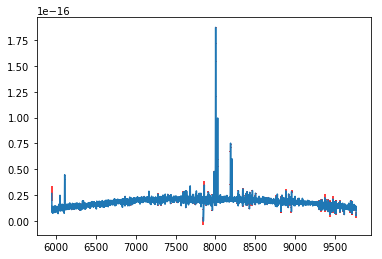

82651.51121110472
[7479.54638672 7721.15185547 7487.92578125 7478.14990234]
[-3.80754605e-17 -1.33433399e-19 -6.35023753e-18  1.15796770e-17]
[1.74922916e-21 4.17855602e-20 8.34768232e-20 1.32827749e-19]
[9000.25       9001.62792969 9000.70898438 9001.16796875]
[5.10246082e-18 4.30497721e-18 2.25807212e-18 1.35627263e-18]
[3.04899736e-17 4.06554254e-17 4.70499159e-17 5.13038940e-17]


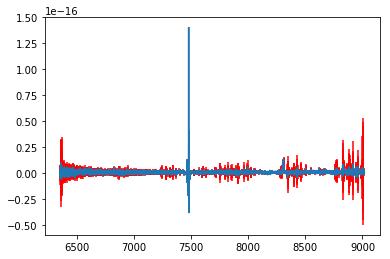

77332.94886412902
[9016.46582031 8557.79101562 8556.85058594 8515.01074219]
[1.57132570e-17 1.56919819e-17 1.49251508e-17 1.66272781e-17]
[2.89133022e-20 2.91526174e-20 2.92440317e-20 2.92900549e-20]
[9375.29296875 9375.75488281 9741.67382812 5909.484375  ]
[2.09323927e-17 2.06197683e-17 8.53385008e-18 2.29466253e-17]
[3.00632677e-18 3.03882961e-18 3.36273572e-18 1.15891429e-17]


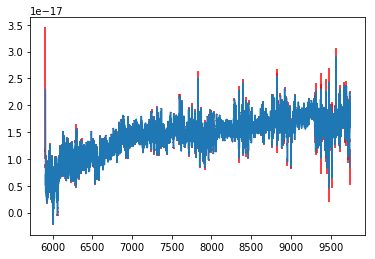

76449.01812674587
[8543.6796875  8583.18945312 8581.77832031 8582.71875   ]
[4.15995237e-17 3.63753918e-17 3.73553636e-17 3.43850630e-17]
[7.02329610e-20 7.11198581e-20 7.11746898e-20 7.15877508e-20]
[9914.36035156 9914.81640625 9961.73046875 9962.18554688]
[ 4.32751868e-17  2.37336347e-17  3.49579218e-17 -2.79311363e-17]
[1.63224516e-17 1.63484169e-17 2.20543539e-17 7.89228075e-17]


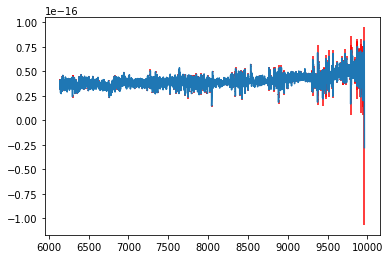

73610.52696616885
[10217.33984375  8313.30078125  6400.39453125 10051.05859375]
[3.06680051e-19 2.87014316e-18 4.38113295e-19 2.32817443e-18]
[3.06642285e-21 5.83025276e-21 7.90417259e-21 8.47175734e-21]
[9956.61914062 9946.97753906 9946.05957031 9946.51855469]
[1.45817569e-17 1.40234493e-17 1.44999772e-17 8.56692821e-18]
[1.72762221e-18 1.82639814e-18 1.86750554e-18 1.90289656e-18]


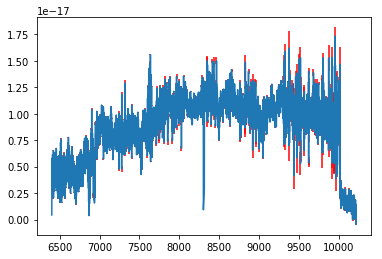

68738.22497815048
[8322.70019531 8543.5        8542.90039062 8499.09960938]
[1.33354130e-19 1.01423733e-19 9.78111155e-20 1.37339887e-19]
[5.10861967e-22 5.21495735e-22 5.28856585e-22 5.59410798e-22]
[6660.69970703 6720.69970703 6681.09960938 6736.89990234]
[3.40429730e-19 3.44029243e-19 3.45919275e-19 3.42008641e-19]
[2.26474639e-21 2.36750300e-21 2.39757736e-21 2.44906798e-21]


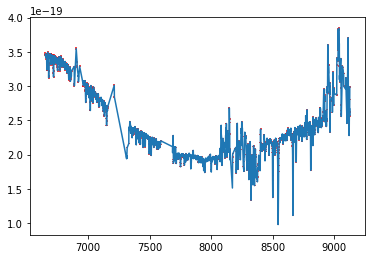

67374.37536636833
[8557.07910156 8556.61035156 8479.72460938 8556.14257812]
[9.27947531e-19 8.08224801e-19 8.03847797e-19 7.60928337e-19]
[1.69865619e-21 1.70106195e-21 1.71348818e-21 1.71806649e-21]
[5913.03222656 9375.328125   9376.24804688 9375.78808594]
[5.99459540e-19 8.68514987e-19 2.07962510e-18 2.14421299e-18]
[3.29598815e-19 3.37001276e-19 3.58496799e-19 3.63918891e-19]


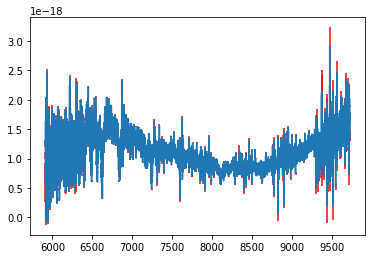

67332.50499748888
[8230.61523438 8228.27246094 8230.14648438 8229.67773438]
[8.89358873e-19 9.57863960e-19 9.63544693e-19 9.29678184e-19]
[2.29101829e-21 2.31031408e-21 2.33325091e-21 2.33657365e-21]
[9718.98339844 9720.34960938 9719.89355469 9719.43847656]
[2.76584929e-18 5.69926574e-18 4.33638923e-18 3.45315423e-18]
[2.89118256e-18 3.19286165e-18 3.53331157e-18 3.60752421e-18]


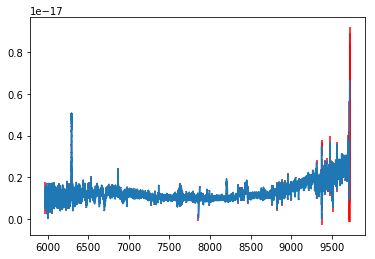

66445.82179928676
[6494.5        6501.69970703 6480.09960938 6486.09960938]
[-1.20334451e-20 -1.17395775e-20 -1.13753338e-20 -1.18936434e-20]
[-4.70825939e-23 -4.40981922e-23 -4.30460640e-23 -4.23497746e-23]
[5811.69970703 5809.89990234 5810.5        7588.29980469]
[1.34234574e-18 1.31282987e-18 1.32631669e-18 3.85913784e-19]
[3.17864243e-20 3.46108342e-20 3.50818957e-20 2.62065171e-19]


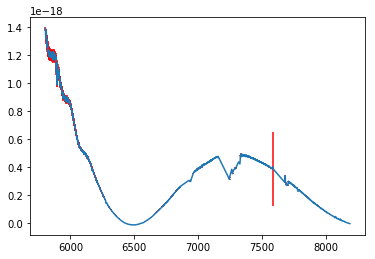

61023.27545763026
[7535.20263672 7534.73291016 7581.73291016 7533.32275391]
[1.47325035e-19 1.24194356e-19 1.76779960e-19 8.78053400e-20]
[4.13079523e-22 4.14184728e-22 4.15261386e-22 4.16874817e-22]
[9476.95019531 9376.375      9375.46289062 9375.91894531]
[ 5.30204545e-19 -1.26529633e-19  4.31483047e-19  6.03715452e-19]
[9.81299651e-20 1.04316006e-19 1.05486811e-19 1.09763457e-19]


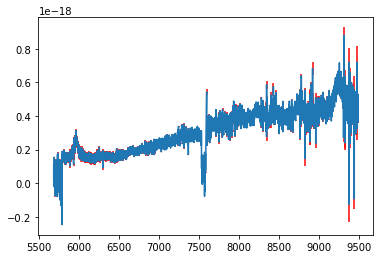

58637.72941552107
[7744.02246094 7731.76416016 7380.75830078 7396.78222656]
[8.64725365e-20 3.52528034e-19 1.77864687e-19 2.02710838e-19]
[3.02916874e-22 5.31252279e-22 7.16152823e-22 7.17562873e-22]
[9476.99707031 9375.5        9376.41992188 9375.95996094]
[3.04134300e-18 1.67562159e-18 1.71650335e-18 1.45905014e-18]
[1.79102616e-19 1.80153612e-19 1.82045492e-19 1.84553741e-19]


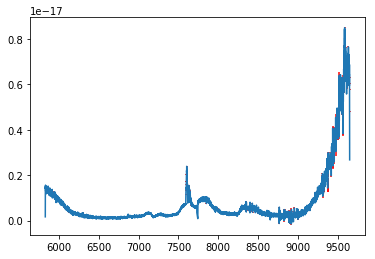

48651.17024750978
[7875.24511719 7874.77587891 7889.10253906 8543.07226562]
[1.74513311e-18 8.79674264e-18 3.09726822e-18 1.40400666e-17]
[9.07233962e-21 2.69855411e-20 3.06176898e-20 3.24858886e-20]
[9376.68066406 9375.30175781 9376.22070312 9375.76171875]
[1.56929251e-17 1.52041387e-17 2.27756140e-18 3.00524546e-18]
[3.50961169e-18 3.77511649e-18 4.13025750e-18 4.14429715e-18]


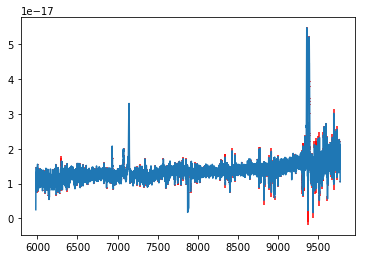

47866.95642220647
[8123.98681641 8132.109375   8123.51708984 8132.57958984]
[1.60783394e-18 9.80816782e-18 4.77332825e-18 1.83573353e-17]
[1.27125701e-20 2.09685058e-20 2.99779643e-20 4.60587288e-20]
[10026.70800781 10027.16308594 10027.6171875  10028.07226562]
[2.61202142e-16 4.03007543e-16 6.44412103e-16 2.56711470e-15]
[1.52311728e-16 2.24448405e-16 4.95346252e-16 7.12559837e-15]


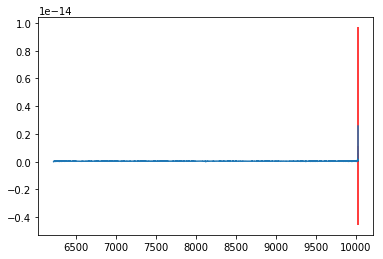

47053.89718894833
[8359.1640625  8370.16601562 6460.06103516 8358.69335938]
[1.08061829e-18 4.62256871e-18 2.46849588e-18 9.22888242e-18]
[1.21668192e-20 1.37208994e-20 2.05216639e-20 4.41868207e-20]
[10026.66113281 10027.12207031 10027.58203125 10028.04199219]
[4.75922453e-16 9.88604184e-16 1.11948720e-15 4.94367699e-15]
[4.74556960e-16 7.47600648e-16 1.64431309e-15 1.61688726e-14]


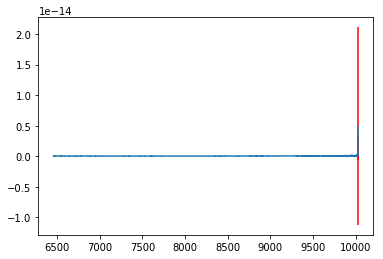

43304.24993944775
[8556.09960938 8509.90039062 8436.70019531 8490.70019531]
[3.08551606e-18 3.33807730e-18 3.32811255e-18 3.40717011e-18]
[6.83418566e-21 7.26847595e-21 7.27950406e-21 7.31665376e-21]
[8052.70019531 7963.29980469 7965.09960938 8134.29980469]
[6.26253932e-18 5.85149056e-18 5.66552085e-18 7.78037645e-18]
[6.43070040e-20 6.58325851e-20 6.77112315e-20 7.66659502e-20]


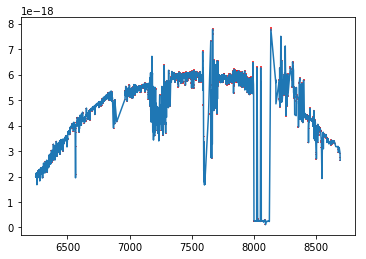

42137.33193851878
[10030.47363281 10030.01464844 10029.55664062 10029.09765625]
[ 1.20281849e-14 -2.47753271e-16 -3.69550411e-17 -4.23503030e-17]
[-1.37192609e-12 -2.80953436e-16 -3.63072709e-17 -1.48544984e-17]
[8826.01660156 8826.48632812 8827.42480469 8826.95605469]
[2.93184297e-19 2.59394089e-19 1.85803364e-19 3.58653522e-19]
[1.20277256e-20 1.46391688e-20 1.51360433e-20 1.56093957e-20]


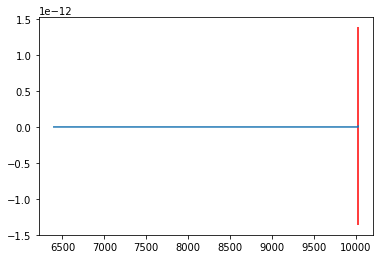

40924.46612287459
[7648.49169922 7637.48974609 9556.10839844 7648.96337891]
[7.47371837e-18 2.23589043e-18 2.80492741e-18 3.75538073e-17]
[3.48544591e-20 5.55399607e-20 6.41617333e-20 1.58185811e-19]
[9376.69921875 9375.32519531 9376.24121094 9375.78320312]
[1.01293935e-16 1.08422848e-16 1.45602014e-16 9.94345866e-17]
[1.35640958e-17 1.44020639e-17 1.50094539e-17 1.50798964e-17]


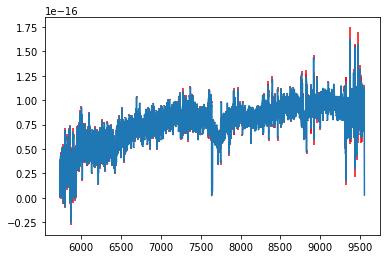

40216.45690692102
[9945.67382812 9946.1328125  9945.21484375 9944.75683594]
[-5.88747588e-20 -4.81201521e-20 -6.85059204e-20 -8.48906901e-20]
[-1.88510786e-20 -1.87047094e-20 -1.85996026e-20 -1.84543356e-20]
[7602.97216797 8329.16894531 8329.93945312 8329.5546875 ]
[3.97640803e-19 3.16473715e-19 3.63569775e-19 3.42916319e-19]
[1.42330597e-20 1.45537852e-20 1.66263909e-20 1.79137889e-20]


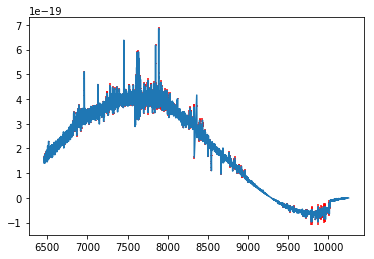

38819.81475411784
[8229.69628906 8229.22558594 8228.28417969 8480.38476562]
[1.75571938e-19 1.81458582e-19 1.80146405e-19 1.60764385e-19]
[5.26572599e-22 5.27214912e-22 5.29593486e-22 5.32858332e-22]
[9956.5625     9946.98632812 9946.07421875 9946.53027344]
[1.05464790e-18 1.95239886e-19 8.71360973e-19 3.09778657e-19]
[1.71402242e-19 1.78589490e-19 1.79073421e-19 1.82958106e-19]


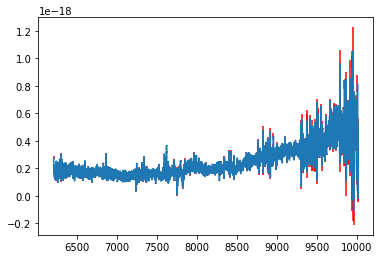

In [188]:
for i in range(1, 100):
    print(hello[np.argsort(hello)[-i]])
    bad_boy = outputs[np.argsort(hello)[-i]]
    num_wavelengths = int(bad_boy[4 * max_num_wavelengths])
    wavelengths = bad_boy[max_num_wavelengths:max_num_wavelengths + num_wavelengths]
    fluxes = bad_boy[2 * max_num_wavelengths:2 * max_num_wavelengths + num_wavelengths]
    errors = bad_boy[3 * max_num_wavelengths:3 * max_num_wavelengths + num_wavelengths]
    print(wavelengths[np.argsort(errors)[:4]])
    print(fluxes[np.argsort(errors)[:4]])
    print(errors[np.argsort(errors)[:4]])
    print(wavelengths[np.argsort(errors)[-4:]])
    print(fluxes[np.argsort(errors)[-4:]])
    print(errors[np.argsort(errors)[-4:]])
    plt.errorbar(wavelengths, fluxes, errors, ecolor='red')
    plt.show()

In [52]:
import time

def numpy_loss(outputs, predicted_fluxes):
    loss = np.empty(len(outputs))
    max_n = max_num_wavelengths
    for i in range(len(outputs)):
        n = int(outputs[i, -1])
        
        wavelengths = outputs[i, max_n:max_n + n]
        fluxes = outputs[i, 2 * max_n:2 * max_n + n]
        errors = outputs[i, 3 * max_n:3 * max_n + n]
        
        interpolation = interp1d(predicted_wavelengths, predicted_fluxes[i])
        interpolated_fluxes = interpolation(wavelengths)
        
        weighted_squared_errors = np.square((fluxes - interpolated_fluxes) / errors)
        loss[i] = np.sum(weighted_squared_errors) / n
    return loss
    
start = time.time()
test = numpy_loss(outputs, predicted_fluxes)
end = time.time()
print(end - start)

6.698600769042969


In [328]:
from keras import backend as K
import time

def keras_loss(outputs, predicted_fluxes):
    batch_size = outputs.shape[0]
    
    interpolation_indices = outputs[:, :max_num_wavelengths]
    wavelengths = outputs[:, max_num_wavelengths:2 * max_num_wavelengths]
    fluxes = outputs[:, 2 * max_num_wavelengths:3 * max_num_wavelengths]
    errors = outputs[:, 3 * max_num_wavelengths:4 * max_num_wavelengths]
    num_wavelengths = outputs[:, 4 * max_num_wavelengths]
    
    slopes = ((predicted_fluxes[:, 1:] - predicted_fluxes[:, :-1]) /
              (k_predicted_wavelengths[1:] - k_predicted_wavelengths[:-1]))
    offsets = predicted_fluxes[:, :-1] - slopes * k_predicted_wavelengths[:-1]
    
    interpolation_indices = K.flatten(K.cast(interpolation_indices, 'int32') +
                                      k_interpolation_index_offsets)
    
    interpolation_slopes = K.reshape(K.gather(K.flatten(slopes),
                                              interpolation_indices),
                                     (batch_size, max_num_wavelengths))
    interpolation_offsets = K.reshape(K.gather(K.flatten(offsets),
                                               interpolation_indices),
                                      (batch_size, max_num_wavelengths))
    
    interpolated_fluxes = (interpolation_slopes * wavelengths +
                           interpolation_offsets)
    
    weighted_squared_errors = K.square((fluxes - interpolated_fluxes) / errors)
    reduced_chi_squared = K.sum(weighted_squared_errors, 1) / num_wavelengths
    
    return reduced_chi_squared

################################################################################

start = time.time()
y_true_ = outputs
y_pred_ = predicted_fluxes
K.clear_session()
K.set_floatx('float64')
y_true = K.placeholder(y_true_.shape)
y_pred = K.placeholder(y_pred_.shape)
k_predicted_wavelengths = K.constant(predicted_wavelengths)
interpolation_index_offsets = np.tile(np.expand_dims(np.arange(len(y_true_)), 1) *
                                      (num_predicted_wavelengths - 1),
                                      (1, max_num_wavelengths))
k_interpolation_index_offsets = K.constant(interpolation_index_offsets, 'int32')
loss_fn = keras_loss(y_true, y_pred)
end = time.time()
print(end - start)

start = time.time()
not_test1 = K.get_session().run(loss_fn, feed_dict={y_true: y_true_, y_pred: y_pred_})
end = time.time()
print(end - start)

5.823503017425537
21.820021629333496


In [329]:
from keras import backend as K
import time

def keras_loss(outputs, predicted_fluxes):
    batch_size = outputs.shape[0]
    
    interpolation_indices = outputs[:, :max_num_wavelengths]
    wavelengths = outputs[:, max_num_wavelengths:2 * max_num_wavelengths]
    fluxes = outputs[:, 2 * max_num_wavelengths:3 * max_num_wavelengths]
    errors = outputs[:, 3 * max_num_wavelengths:4 * max_num_wavelengths]
    num_wavelengths = outputs[:, 4 * max_num_wavelengths]
    
    slopes = ((predicted_fluxes[:, 1:] - predicted_fluxes[:, :-1]) /
              (k_predicted_wavelengths[1:] - k_predicted_wavelengths[:-1]))
    offsets = predicted_fluxes[:, :-1] - slopes * k_predicted_wavelengths[:-1]
    
    interpolation_index_offsets = K.tile(K.expand_dims(K.arange(batch_size)) *
                                         (num_predicted_wavelengths - 1),
                                         (1, max_num_wavelengths))
    
    interpolation_indices = (K.cast(K.flatten(interpolation_indices), 'int32') +
                             K.flatten(interpolation_index_offsets))
    
    interpolation_slopes = K.reshape(K.gather(K.flatten(slopes),
                                              interpolation_indices),
                                     (batch_size, max_num_wavelengths))
    interpolation_offsets = K.reshape(K.gather(K.flatten(offsets),
                                               interpolation_indices),
                                      (batch_size, max_num_wavelengths))
    
    interpolated_fluxes = (interpolation_slopes * wavelengths +
                           interpolation_offsets)

    weighted_squared_errors = K.square((fluxes - interpolated_fluxes) / errors)
    reduced_chi_squared = K.sum(weighted_squared_errors, 1) / num_wavelengths
    
    return reduced_chi_squared

################################################################################

start = time.time()
y_true_ = outputs
y_pred_ = predicted_fluxes
K.clear_session()
K.set_floatx('float64')
y_true = K.placeholder(y_true_.shape)
y_pred = K.placeholder(y_pred_.shape)
k_predicted_wavelengths = K.variable(predicted_wavelengths)
loss_fn = keras_loss(y_true, y_pred)
end = time.time()
print(end - start)

start = time.time()
not_test2 = K.get_session().run(loss_fn, feed_dict={y_true: y_true_, y_pred: y_pred_})
end = time.time()
print(end - start)

0.15784311294555664
16.682891130447388


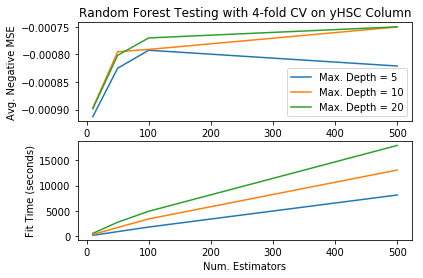

[[10 5 'auto' -91288.24384703636 182.098093688488]
 [50 5 'auto' -82496.33622796193 906.1462435126305]
 [100 5 'auto' -79237.48862426209 1811.7246014475822]
 [500 5 'auto' -82093.28170325953 8128.913308262825]
 [10 5 'sqrt' -108291.01403215966 28.036456763744354]
 [50 5 'sqrt' -95677.37577428004 136.6431884765625]
 [100 5 'sqrt' -92392.66404029544 267.1263865828514]
 [500 5 'sqrt' -88524.32635525007 1327.0757511854172]
 [10 10 'auto' -89717.49269250802 347.48356580734253]
 [50 10 'auto' -79500.84121381067 1722.538121163845]
 [100 10 'auto' -79085.32497149071 3418.06063580513]
 [500 10 'auto' -75015.6906409436 13051.108522295952]
 [10 10 'sqrt' -82685.45231429115 50.58607596158981]
 [50 10 'sqrt' -82971.71200449404 252.67220228910446]
 [100 10 'sqrt' -82421.62294071494 505.50974118709564]
 [500 10 'sqrt' -80539.61473253506 2526.5932250618935]
 [10 20 'auto' -89828.31914605398 564.4461513757706]
 [50 20 'auto' -80149.28923019412 2754.8854860067368]
 [100 20 'auto' -77003.13562690388 4922

In [53]:
results = param_searcher.cv_results_
table = np.vstack((results['param_n_estimators'], results['param_max_depth'],
                   results['param_max_features'], results['mean_test_score'],
                   results['mean_fit_time'])).T
for index in range(3):
    rows = table[8 * index:8 * index + 4]
    plt.subplot(2, 1, 1)
    plt.plot(rows[:, 0], rows[:, 3] * 1e-8)
    plt.subplot(2, 1, 2)
    plt.plot(rows[:, 0], rows[:, 4])
plt.subplot(2, 1, 1)
plt.legend(['Max. Depth = 5', 'Max. Depth = 10', 'Max. Depth = 20'])
plt.title('Random Forest Testing with 4-fold CV on yHSC Column')
plt.ylabel('Avg. Negative MSE')
plt.subplot(2, 1, 2)
plt.xlabel('Num. Estimators')
plt.ylabel('Fit Time (seconds)')
plt.show()
print(table)

In [9]:
print(param_searcher.best_params_)
print(repr(param_searcher.cv_results_))

{'n_estimators': 500, 'max_features': 'auto', 'max_depth': 20}
{'mean_score_time': array([ 0.15533632,  0.59351587,  1.06582814,  3.17024839,  0.14055347,
        0.51219183,  0.94933027,  4.48362738,  0.21841222,  0.88741106,
        1.60965055,  6.12406015,  0.21148258,  0.86483753,  1.66244805,
        7.99679971,  0.61207545,  2.43042189,  4.10550916, 17.80885893,
        0.61375815,  2.9398182 ,  5.76832342, 21.92914808]), 'split3_test_score': array([-220718.13465759, -208750.1979178 , -184965.99140476,
       -197359.1980404 , -278893.61110733, -234005.69600054,
       -236510.78482301, -223101.15193704, -213817.59105994,
       -184787.79278967, -198762.46172844, -186606.38652675,
       -197840.91374183, -215573.26509888, -214118.05109378,
       -209129.27026707, -212673.19462144, -196806.08376574,
       -191170.73694114, -185920.30604801, -240522.46487774,
       -213344.97427014, -217552.50529265, -208934.38081378]), 'params': [{'n_estimators': 10, 'max_features': 'auto', '

In [78]:
import time

while True:
    time.sleep(600)
    print('Hello World')

Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hell

KeyboardInterrupt: 

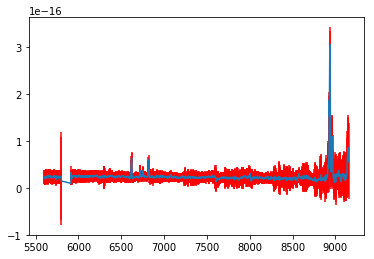

In [237]:
name = 'Magellan'
lambdas, fluxes, flux_errors = read_spec_file(name,
                                              spec_table[spec_table['name'] == name][1000]['path'],
                                              zbright_errors, True)
plt.errorbar(lambdas, fluxes, flux_errors, ecolor='red', zorder=1)
plt.show()

In [290]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse
from keras import backend as K

class VAE:
    
    def __init__(self, original_ndim, latent_ndim, intermediate_ndims):        
        # Build the encoder.
        original_input = Input(shape=(original_ndim,))
        prev_layer = original_input
        for intermediate_ndim in intermediate_ndims:
            prev_layer = Dense(intermediate_ndim, activation='relu')(prev_layer)
        latent_mean = Dense(latent_ndim)(prev_layer)
        latent_log_var = Dense(latent_ndim)(prev_layer)
        
        def sample_latent(args):
            # Sample from a normal distribution centered at latent_mean with
            # variance exp(latent_log_var).
            latent_mean, latent_log_var = args
            batch_size = K.shape(latent_mean)[0]
            epsilon = K.random_normal(shape=(batch_size, latent_ndim))
            return latent_mean + K.exp(0.5 * latent_log_var) * epsilon
        
        latent_output = Lambda(sample_latent)([latent_mean, latent_log_var])
        self.encoder = Model(original_input,
                             [latent_mean, latent_log_var, latent_output])

        # Build the decoder.
        latent_input = Input(shape=(latent_ndim,))
        prev_layer = latent_input
        for intermediate_ndim in reversed(intermediate_ndims):
            prev_layer = Dense(intermediate_ndim, activation='relu')(prev_layer)
        original_output = Dense(original_ndim)(prev_layer)
        self.decoder = Model(latent_input, original_output)

        # Build the full auto-encoder.
        restored_input = self.decoder(self.encoder(original_input)[2])
        self.autoencoder = Model(original_input, restored_input)
        
        restoration_loss = mse(original_input, restored_input) * original_ndim
        kl_loss = -K.sum(1 + latent_log_var - K.square(latent_mean) -
                         K.exp(latent_log_var), axis=-1) / 2
        self.autoencoder.add_loss(K.mean(restoration_loss + kl_loss))
        
        self.autoencoder.compile(optimizer='adam')
        
        # Record that no training has occured yet.
        self.last_epoch = 0
        
    def train(self, training_data, validation_data, epochs, backup_name=None):
        self.last_epoch += epochs
        self.autoencoder.fit(training_data, epochs=self.last_epoch,
                             validation_data=(validation_data, None))
        if backup_name:
            self.autoencoder.save_weights(backup_name + '.h5')
        
    def load(self, backup_name):
        self.autoencoder.load_weights(backup_name + '.h5')
    
    def to_latent(self, original):
        return self.encoder.predict(original)[0]
    
    def from_latent(self, latent):
        return self.decoder.predict(latent)

################################################################################

# Visualize the 2D or 3D latent space.
def plot_results(vae, data, labels, filename=None):
    latent_data = vae.to_latent(data)
    fig = plt.figure(figsize=(12, 10))
    if latent_data.shape[1] == 2:
        ax = fig.gca()
    else:
        ax = fig.gca(projection='3d')
    p = ax.scatter(*latent_data.T, c=labels)
    fig.colorbar(p)
    if filename:
        fig.savefig(filename + '.png')
    plt.show()

################################################################################

split_index = int(0.8 * len(colors))

vae = VAE(len(bands), 2, [100, 10])
vae.train(colors[:split_index], colors[split_index:], 1, 'vae_cosmos')

has_specz = np.nan_to_num(speczs) > 0
plot_results(vae, colors[has_specz], speczs[has_specz])

Using TensorFlow backend.
W0712 16:51:59.461615 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 16:51:59.510530 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 16:51:59.538975 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0712 16:51:59.697676 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0712 16:52:00.111408 61144 deprecation_wrapper

Train on 257293 samples, validate on 64324 samples
Epoch 1/1
 72960/257293 [=======>......................] - ETA: 1:41:58 - loss: 78249744.000 - ETA: 37:00 - loss: 26898034.2708  - ETA: 23:34 - loss: 16235359.646 - ETA: 17:58 - loss: 11626747.066 - ETA: 14:44 - loss: 11607540.351 - ETA: 12:45 - loss: 9619133.165 - ETA: 11:21 - loss: 8142190.53 - ETA: 9:04 - loss: 6230568.3000 - ETA: 8:04 - loss: 5298189.445 - ETA: 7:18 - loss: 4608987.819 - ETA: 6:02 - loss: 3657973.586 - ETA: 4:55 - loss: 2870088.646 - ETA: 4:07 - loss: 2311110.556 - ETA: 3:42 - loss: 2007531.874 - ETA: 3:23 - loss: 1774723.962 - ETA: 3:16 - loss: 1664494.470 - ETA: 3:03 - loss: 1501424.439 - ETA: 2:49 - loss: 1350664.537 - ETA: 2:48 - loss: 1301648.535 - ETA: 2:43 - loss: 1227460.040 - ETA: 2:37 - loss: 1149142.277 - ETA: 2:41 - loss: 1125211.609 - ETA: 2:26 - loss: 1000377.838 - ETA: 2:21 - loss: 939633.952 - ETA: 2:13 - loss: 864723.59 - ETA: 2:07 - loss: 806881.65 - ETA: 2:06 - loss: 783626.99 - ETA: 2:04 - loss:

KeyboardInterrupt: 

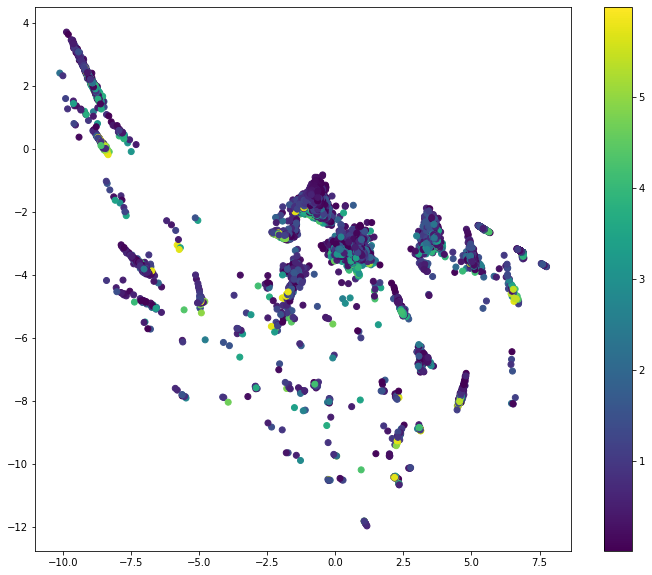

In [97]:
has_photozs= np.nan_to_num(photozs) > 0
plot_results(vae, colors[has_photozs], photozs[has_photozs])